In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# === Pfade & Parameter ===
CSV_PATH   = "PnLCalib/output/1_1_transformed.csv"   
MIN_FRAMES = 7500               # <-- Mindest-Lebensdauer (in Frames) für Spieler-Tracklets
PLAYER_CLASSES = {"L", "R"}     # nur Spieler für Lebensdauer-/Jersey-Filter

# Spielfeld & Off-Pitch-Filter
PITCH_LENGTH = 105.0            # Meter
PITCH_WIDTH  = 68.0             # Meter
OFFPITCH_MARGIN = 3.0           # Meter Toleranz außerhalb des Spielfelds

# === CSV laden ===
df = pd.read_csv(CSV_PATH)

# Spaltennamen vereinheitlichen
df.columns = [c.strip().lower() for c in df.columns]

# Erwartete Spalten prüfen (sanft)
expected = {"frame", "id", "model_x", "model_y", "class", "jersey"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Fehlende Spalten in CSV: {missing}. Gefunden: {list(df.columns)}")

# Datentypen bereinigen
df["frame"]   = pd.to_numeric(df["frame"], errors="coerce").astype("Int64")
df["id"]      = pd.to_numeric(df["id"], errors="coerce").astype("Int64")
df["model_x"] = pd.to_numeric(df["model_x"], errors="coerce")
df["model_y"] = pd.to_numeric(df["model_y"], errors="coerce")
# class normalisieren (Großschreibung, '_' -> '-', Trim)
df["class"]   = (df["class"].astype(str).str.strip().str.upper().str.replace("_", "-", regex=False))
# jersey als nullable Integer
df["jersey"]  = pd.to_numeric(df["jersey"], errors="coerce").astype("Int64")

# === Off-Pitch-Filter (global, für alle Klassen) ===
onpitch_mask = (
    (df["model_x"] >= -OFFPITCH_MARGIN) & (df["model_x"] <= PITCH_LENGTH + OFFPITCH_MARGIN) &
    (df["model_y"] >= -OFFPITCH_MARGIN) & (df["model_y"] <= PITCH_WIDTH  + OFFPITCH_MARGIN)
)
n_in_rows_total = len(df)
df = df.loc[onpitch_mask].copy()
n_offpitch = n_in_rows_total - len(df)

# === Lebensdauer (Frames) pro Tracklet-Key (ID, Class, Jersey) ===
group_cols = ["id", "class", "jersey"]
life = (
    df.groupby(group_cols, dropna=False)["frame"]
      .nunique()  # unique Frames als Lebensdauer
      .rename("n_frames")
      .reset_index()
)

# === Gültige Spieler-Tracklets bestimmen ===
is_player_group = life["class"].isin(PLAYER_CLASSES)
has_jersey      = life["jersey"].notna() & (life["jersey"] != -1)
long_enough     = life["n_frames"] >= MIN_FRAMES

valid_player_groups = life[is_player_group & has_jersey & long_enough]
valid_player_keys = set(map(tuple, valid_player_groups[group_cols].to_numpy()))

# === Masken auf Zeilenebene: Spieler gefiltert, Non-Player ungefiltert ===
is_player_row   = df["class"].isin(PLAYER_CLASSES)
row_keys        = list(zip(df["id"], df["class"], df["jersey"]))
keep_players    = np.fromiter((k in valid_player_keys for k in row_keys), dtype=bool)
keep_nonplayer  = ~is_player_row  # Non-Player immer behalten
keep_mask       = keep_nonplayer | keep_players

df_filtered = (
    df[keep_mask]
    .sort_values(["frame", "id"])
    .reset_index(drop=True)
)

# === Diagnose: was wurde rausgefiltert und warum? ===
player_groups = life[is_player_group].copy()

# welche Gruppen wurden gedroppt?
drop_mask = ~player_groups[group_cols].apply(tuple, axis=1).isin(valid_player_keys)

# Startzustand
player_groups["reason_drop"] = "kept"

# Feingründe
mask_invalid_jersey = player_groups["jersey"].isna() | (player_groups["jersey"] == -1)
mask_too_short      = player_groups["n_frames"] < MIN_FRAMES

player_groups.loc[drop_mask & mask_invalid_jersey, "reason_drop"] = "no_jersey"
player_groups.loc[drop_mask & ~mask_invalid_jersey & mask_too_short, "reason_drop"] = "too_short"
player_groups.loc[drop_mask & ~mask_invalid_jersey & ~mask_too_short, "reason_drop"] = "other"

# === Zusammenfassung ausgeben ===
n_out_rows  = len(df_filtered)
n_kept_pct  = 100.0 * n_out_rows / max(1, n_in_rows_total)

n_in_groups     = len(player_groups)
n_kept_groups   = (player_groups["reason_drop"] == "kept").sum()

print(f"Off-Pitch gedroppt: {n_offpitch} Zeilen (Margin={OFFPITCH_MARGIN} m, Pitch={PITCH_LENGTH}×{PITCH_WIDTH}).")
print(f"Zeilen: {n_out_rows}/{n_in_rows_total} behalten ({n_kept_pct:.1f}%).")
print(f"Spieler-Tracklet-Gruppen (ID,Class,Jersey): {n_kept_groups}/{n_in_groups} behalten "
      f"(min_frames={MIN_FRAMES}, jersey != -1).")

dropped_summary = (
    player_groups[player_groups["reason_drop"] != "kept"]
    .sort_values(["reason_drop", "n_frames"], ascending=[True, False])
    .reset_index(drop=True)
)
print("Top 10 verworfene Spieler-Tracklets:")
display(dropped_summary.head(10))


Off-Pitch gedroppt: 62711 Zeilen (Margin=3.0 m, Pitch=105.0×68.0).
Zeilen: 498951/889796 behalten (56.1%).
Spieler-Tracklet-Gruppen (ID,Class,Jersey): 24/1178 behalten (min_frames=7500, jersey != -1).
Top 10 verworfene Spieler-Tracklets:


,id,class,jersey,n_frames,reason_drop
0,924,L,-1,1685,no_jersey
1,237,L,-1,1643,no_jersey
2,836,L,-1,1466,no_jersey
3,810,R,-1,1357,no_jersey
4,826,R,-1,1341,no_jersey
5,818,R,-1,1325,no_jersey
6,644,R,-1,1232,no_jersey
7,254,R,-1,1204,no_jersey
8,834,R,-1,1143,no_jersey
9,569,R,-1,1118,no_jersey


In [ ]:
# === Interaktive Pfad-Visualisierung: 1:1 Mapping ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mplsoccer import Pitch
from ipywidgets import Dropdown, VBox, HTML, Output
from IPython.display import display

assert 'df_filtered' in globals()

PLAYER_CLASSES = {"L", "R", "GK-L", "GK-R"}
PITCH_LENGTH, PITCH_WIDTH = 105, 68
FPS = 25                     # Frames pro Sekunde deines Videos/Trackings
FRAME_BREAK = 250            # >250 Frames Lücke => keine Linie zeichnen (nur Punkte)
INVERT_Y = False             # True, wenn y von oben nach unten wächst (Bildkoords)
MAX_SPEED_KMH = 40.0
SMOOTH_WIN = 5

# Zonen in km/h: (Label, min_incl, max_excl)
SPEED_ZONES = [
    ("Stand/Geh", 0.0,   7.0),
    ("Jog",       7.0,  14.0),
    ("Lauf",     14.0,  21.0),
    ("HSR",      21.0,  24.0),   # High-Speed-Run ≥21 km/h (Paper)
    ("Sprint",   24.0,  float("inf")),  # Sprint >24 km/h (Paper)
]

# Farben pro Zone
ZONE_COLORS = {
    "Stand/Geh": "tab:gray",
    "Jog":       "tab:green",
    "Lauf":      "tab:blue",
    "HSR":       "tab:orange",
    "Sprint":    "tab:red",
} 

players = (
    df_filtered[df_filtered["class"].isin(PLAYER_CLASSES)]
    .dropna(subset=["model_x", "model_y"])
)

if players.empty:
    print("Keine Spieler-Tracklets vorhanden (nach Filter).")
else:
    # Dropdown-Optionen bauen
    tracklet_stats = (
        players.groupby(["id", "class", "jersey"])["frame"]
        .nunique().rename("n_frames").reset_index()
        .sort_values(["class", "jersey", "id", "n_frames"], ascending=[True, True, True, False])
    )
    options = []
    for _, row in tracklet_stats.iterrows():
        tid, cls, jer, n = int(row["id"]), str(row["class"]), int(row["jersey"]), int(row["n_frames"])
        options.append((f"{cls} #{jer:>2} | ID={tid:<4} | frames={n}", (tid, cls, jer)))

    dd = Dropdown(options=options, description="Tracklet:", layout={"width": "600px"})
    header = HTML("<b>Pfad-Visualisierung (1:1)</b> – wähle ein Tracklet.")
    zone_html = HTML("")
    info = HTML("")
    
    out = Output()

    def _zone_for_speed(v_kmh: float) -> str:
        for label, vmin, vmax in SPEED_ZONES:
            if vmin <= v_kmh < vmax:
                return label
        return SPEED_ZONES[-1][0]

    def plot_tracklet(key):
        tid, cls, jer = key
        sub = (
            players[(players["id"] == tid) & (players["class"] == cls) & (players["jersey"] == jer)]
            .sort_values("frame")
            .dropna(subset=["model_x", "model_y"])
        )
        with out:
            out.clear_output()

        if sub.empty:
            zone_html.value = ""  # nichts anzeigen
            with out: print("Keine Punkte für diese Auswahl gefunden.")
            return

        frames = sub["frame"].to_numpy()
        x_raw = sub["model_x"].to_numpy(float)
        y_raw = sub["model_y"].to_numpy(float)
        if INVERT_Y:
            y_raw = PITCH_WIDTH - y_raw

        # Glättung (robust gegen Ausreißer/ID-Zittern)
        x = pd.Series(x_raw).rolling(SMOOTH_WIN, center=True, min_periods=1).median().to_numpy()
        y = pd.Series(y_raw).rolling(SMOOTH_WIN, center=True, min_periods=1).median().to_numpy()

        # Kanten
        df = np.diff(frames)
        dx = np.diff(x)
        dy = np.diff(y)

        valid_dt = df > 0
        dt_s = np.where(valid_dt, df / float(FPS), np.nan)
        dist_m = np.hypot(dx, dy)
        v_ms  = dist_m / dt_s
        v_kmh = v_ms * 3.6

        break_edge     = df > FRAME_BREAK
        overspeed_edge = v_kmh > MAX_SPEED_KMH
        connect_edge   = (~break_edge) & (~overspeed_edge) & valid_dt & np.isfinite(v_kmh)

        # Segmente + Farben
        segs, seg_colors, speeds_kept = [], [], []
        for i in np.where(connect_edge)[0]:
            segs.append([(x[i], y[i]), (x[i+1], y[i+1])])
            zlabel = _zone_for_speed(float(v_kmh[i]))
            seg_colors.append(ZONE_COLORS.get(zlabel, "black"))
            speeds_kept.append(float(v_kmh[i]))

        # Punkte: Overspeed-Endpunkte nicht scattern
        keep_point = np.ones(len(frames), dtype=bool)
        for i in np.where(overspeed_edge)[0]:
            keep_point[i]   = False
            keep_point[i+1] = False

        # === Tempoverteilung für gezeichnete Segmente ===
        # Zeit & Distanz je Zone akkumulieren (nur connect_edge)
        zone_time = {lbl: 0.0 for (lbl, _, _) in SPEED_ZONES}
        zone_dist = {lbl: 0.0 for (lbl, _, _) in SPEED_ZONES}
        idx = np.where(connect_edge)[0]
        for i in idx:
            zlbl = _zone_for_speed(float(v_kmh[i]))
            zone_time[zlbl] += float(dt_s[i])         # Sekunden
            zone_dist[zlbl] += float(dist_m[i])       # Meter

        tot_t = sum(zone_time.values())
        tot_d = sum(zone_dist.values())

        # HTML-Tabelle bauen (Zeit- und Distanzanteile in %)
        if tot_t > 0 or tot_d > 0:
            rows = []
            rows.append("<tr><th style='text-align:left'>Zone</th>"
                        "<th style='text-align:right'>Zeit %</th>"
                        "<th style='text-align:right'>Zeit [s]</th>"
                        "<th style='text-align:right'>Distanz %</th>"
                        "<th style='text-align:right'>Distanz [m]</th></tr>")
            for (lbl, _, _) in SPEED_ZONES:
                t = zone_time[lbl]
                d = zone_dist[lbl]
                t_pct = (t / tot_t * 100.0) if tot_t > 0 else 0.0
                d_pct = (d / tot_d * 100.0) if tot_d > 0 else 0.0
                color = ZONE_COLORS.get(lbl, "black")
                rows.append(
                    f"<tr>"
                    f"<td><span style='display:inline-block;width:10px;height:10px;background:{color};margin-right:6px;'></span>{lbl}</td>"
                    f"<td style='text-align:right'>{t_pct:5.1f}</td>"
                    f"<td style='text-align:right'>{t:6.1f}</td>"
                    f"<td style='text-align:right'>{d_pct:5.1f}</td>"
                    f"<td style='text-align:right'>{d:6.1f}</td>"
                    f"</tr>"
                )
            zone_html.value = (
                "<div style='font-family:monospace'>"
                "<b>Tempozonen-Verteilung (nur gezeichnete Segmente)</b>"
                f"<br><small>Summe: Zeit={tot_t:.1f}s | Distanz={tot_d:.1f}m</small>"
                "<table style='border-collapse:collapse;margin-top:4px'>" +
                "".join(rows) +
                "</table></div>"
            )
        else:
            zone_html.value = "<i>Keine verbindbaren Segmente → keine Tempoverteilung.</i>"

        # === Plot ===
        pitch = Pitch(
            pitch_type="custom",
            pitch_length=PITCH_LENGTH,
            pitch_width=PITCH_WIDTH,
            line_zorder=2,
            linewidth=1.5,
        )
        fig, ax = pitch.draw(figsize=(9, 6))
        ax.set_xlim(0, PITCH_LENGTH)
        ax.set_ylim(0, PITCH_WIDTH)
        ax.set_aspect('equal', adjustable='box')

        if keep_point.any():
            ax.scatter(x[keep_point], y[keep_point], s=10, alpha=0.6, zorder=3)

        if segs:
            lc = LineCollection(segs, colors=seg_colors, linewidths=2.2, zorder=4)
            ax.add_collection(lc)

        kept_idx = np.where(keep_point)[0]
        if kept_idx.size > 0:
            ax.scatter(x[kept_idx[0]], y[kept_idx[0]], s=70, marker="o", zorder=5)
            ax.scatter(x[kept_idx[-1]], y[kept_idx[-1]], s=90, marker="X", zorder=5)

        n_frames = sub["frame"].nunique()
        ax.set_title(f"{cls} #{jer} | ID={tid} | Frames: {n_frames} | FPS={FPS}", pad=12)

        # Legende
        handles = [Line2D([0], [0], color=ZONE_COLORS[lbl], lw=3, label=lbl) for (lbl, _, _) in SPEED_ZONES]
        leg = ax.legend(handles=handles, loc="upper right", frameon=True, title="Tempozonen (km/h)")
        leg._legend_box.align = "left"

        # Infozeile
        overspeed_edges_cnt = int(np.nansum(overspeed_edge))
        dropped_points_cnt  = int((~keep_point).sum())
        if len(speeds_kept):
            vmin, vmax, vmean = np.min(speeds_kept), np.max(speeds_kept), np.mean(speeds_kept)
            info.value = (
                f"<code>Segm.-v (km/h): min={vmin:.1f}, mean={vmean:.1f}, max={vmax:.1f} | "
                f"Segmente={len(segs)} | Overspeed-Kanten(&gt;{MAX_SPEED_KMH})={overspeed_edges_cnt} | "
                f"Scatter gedroppt={dropped_points_cnt} | Break &gt;{FRAME_BREAK}</code>"
            )
        else:
            info.value = (
                f"<code>Keine verbindbaren Segmente | Overspeed-Kanten(&gt;{MAX_SPEED_KMH})={overspeed_edges_cnt} | "
                f"Scatter gedroppt={dropped_points_cnt}</code>"
            )

        with out:
            plt.show()

if options:
    plot_tracklet(options[0][1])

def _on_change(ch):
    if ch["name"] == "value" and ch["new"] is not None:
        plot_tracklet(ch["new"])

dd.observe(_on_change, names="value")

ui = VBox([header, dd, info, zone_html, out])
display(ui)


In [ ]:
# === Frames über Tempo-Threshold aus players entfernen ===
import pandas as pd
import numpy as np

def filter_players_by_speed(players_df: pd.DataFrame,
                            fps: float,
                            max_speed_kmh: float,
                            smooth_win: int = 5,
                            drop_mode: str = "both"  # "both" | "next" | "prev"
                            ) -> pd.DataFrame:
    """
    Entfernt Zeilen (Frames) aus players_df, die zu Kanten mit v > max_speed_kmh gehören.
    - Glättet x/y mit rolling median (smooth_win), berechnet v pro Kante (i->i+1).
    - drop_mode:
        "both":  droppt i und i+1 (robust, konservativ)
        "next":  droppt nur i+1  (häufig sinnvoll: nur der 'Sprung' fällt raus)
        "prev":  droppt nur i
    """
    cols_needed = {"id","class","jersey","frame","model_x","model_y"}
    missing = cols_needed - set(players_df.columns)
    if missing:
        raise ValueError(f"Fehlende Spalten in players_df: {missing}")

    keep_mask_all = []
    idx_all = []

    # pro Tracklet
    giter = (players_df.sort_values(["id","class","jersey","frame"])
                        .groupby(["id","class","jersey"], sort=False))
    for (tid, cls, jer), grp in giter:
        g = grp.copy()
        if g["frame"].nunique() < 2:
            keep_mask_all.append(np.ones(len(g), dtype=bool))
            idx_all.append(g.index.to_numpy())
            continue

        x = pd.Series(g["model_x"].to_numpy(float)).rolling(smooth_win, center=True, min_periods=1).median().to_numpy()
        y = pd.Series(g["model_y"].to_numpy(float)).rolling(smooth_win, center=True, min_periods=1).median().to_numpy()
        frames = g["frame"].to_numpy()

        df = np.diff(frames)
        valid = df > 0
        dt_s = np.where(valid, df / float(fps), np.nan)
        v_kmh = (np.hypot(np.diff(x), np.diff(y)) / dt_s) * 3.6

        overs = v_kmh > max_speed_kmh
        keep = np.ones(len(g), dtype=bool)

        overs_idx = np.where(overs & np.isfinite(v_kmh))[0]
        if overs_idx.size:
            if drop_mode == "both":
                keep[overs_idx] = False
                keep[overs_idx + 1] = False
            elif drop_mode == "next":
                keep[overs_idx + 1] = False
            elif drop_mode == "prev":
                keep[overs_idx] = False
            else:
                raise ValueError("drop_mode muss 'both', 'next' oder 'prev' sein.")

        idx_all.append(g.index.to_numpy())
        keep_mask_all.append(keep)

    if not keep_mask_all:
        players_speedfiltered = players_df.copy()
    else:
        idx_all = np.concatenate(idx_all)
        keep_all = np.concatenate(keep_mask_all)
        keep_series = pd.Series(keep_all, index=idx_all).sort_index()
        players_speedfiltered = players_df.loc[keep_series.index[keep_series.values]] \
                                         .sort_values(["id","class","jersey","frame"]) \
                                         .reset_index(drop=True)

    return players_speedfiltered

# === Parameter Visualisierungszelle nutzen ===
players_speedfiltered = filter_players_by_speed(
    players_df=players,
    fps=FPS,
    max_speed_kmh=MAX_SPEED_KMH,
    smooth_win=SMOOTH_WIN,
    drop_mode="both",   # oder "next", wenn du nur der 'Sprung'-Frame gedroppt werden soll
)

print(f"players_speedfiltered: {len(players_speedfiltered)}/{len(players)} Zeilen behalten "
      f"({100*len(players_speedfiltered)/max(1,len(players)):.1f}%).")


players_speedfiltered: 411776/426894 Zeilen behalten (96.5%).


In [ ]:
# === Heatmaps aus players_speedfiltered ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from ipywidgets import Dropdown, IntSlider, FloatSlider, ToggleButtons, VBox, HBox, HTML, Output, Checkbox
from IPython.display import display

# ---- Voraussetzungen ----
assert 'players_speedfiltered' in globals(), "players_speedfiltered fehlt. Bitte vorher erzeugen."
assert 'FPS' in globals(), "FPS fehlt. Bitte in den Parametern definieren (z.B. FPS=25)."

PITCH_LENGTH, PITCH_WIDTH = globals().get('PITCH_LENGTH', 105), globals().get('PITCH_WIDTH', 68)
INVERT_Y = globals().get('INVERT_Y', False)

# verfügbare Tracklets aus dem gefilterten Set
g = (players_speedfiltered
     .dropna(subset=['model_x','model_y'])
     .groupby(['id','class','jersey'])
     .agg(n_frames=('frame','nunique'))
     .reset_index()
     .sort_values(['class','jersey','id','n_frames'], ascending=[True,True,True,False]))

if g.empty:
    raise ValueError("Keine Daten in players_speedfiltered.")

# Dropdown (Tracklet)
options = []
for _, r in g.iterrows():
    tid, cls, jer, nf = int(r.id), str(r['class']), int(r.jersey), int(r.n_frames)
    options.append((f"{cls} #{jer:>2} | ID={tid:<4} | frames={nf}", (tid, cls, jer)))
dd_player = Dropdown(options=options, description="Tracklet:", layout={'width': '520px'})

# Rastergröße (M×M) – im Paper wurde u.a. M=5 (P=25) betrachtet
grid_M = IntSlider(value=4, min=4, max=40, step=1, description="Raster M:", continuous_update=False)
grid_show = Checkbox(value=True, description="Raster einblenden")

# Glättung (Gaussian, optional)
sigma = FloatSlider(value=0.8, min=0.0, max=3.0, step=0.1, description="Glättung σ:", continuous_update=False)

# Normierung der Darstellung
norm_mode = ToggleButtons(options=[('Sekunden','sec'), ('Prozent','pct')],
                          value='sec', description='Norm:')

# Ausgabe
info = HTML("")
out = Output()

def _compute_heatmap_for_key(key, M: int, sigma_val: float, mode: str):
    """Tracking-Heatmap (Zeit in Zellen) für ein Tracklet berechnen und zeichnen."""
    tid, cls, jer = key
    df = (players_speedfiltered[(players_speedfiltered['id']==tid)
                                & (players_speedfiltered['class']==cls)
                                & (players_speedfiltered['jersey']==jer)]
                                .sort_values('frame'))
    if df.empty or df['frame'].nunique() < 2:
        with out:
            out.clear_output()
            print("Zu wenige Punkte für Heatmap.")
        return

    x = df['model_x'].to_numpy(float)
    y = df['model_y'].to_numpy(float)
    if INVERT_Y:
        y = PITCH_WIDTH - y
    fr = df['frame'].to_numpy(int)

    # Zeitgewicht pro Kante (i -> i+1)
    df_frames = np.diff(fr)
    valid = df_frames > 0
    if not np.any(valid):
        with out:
            out.clear_output()
            print("Keine gültigen Zeitdifferenzen (Frames nicht strikt steigend).")
        return
    dt = (df_frames[valid] / float(FPS))  # Sekunden
    # die Position für die Gewichtung: wir nehmen den Startpunkt der Kante
    xi = x[:-1][valid]
    yi = y[:-1][valid]

    # 2D-Histogramm über das Spielfeld, gewichtet mit dt (→ Aufenthaltszeit pro Zelle)
    H, y_edges, x_edges = np.histogram2d(
        yi, xi,
        bins=(M, M),
        range=((0, PITCH_WIDTH), (0, PITCH_LENGTH)),
        weights=dt
    )

    # optionale Glättung
    if sigma_val and sigma_val > 0.0:
        try:
            from scipy.ndimage import gaussian_filter
            H = gaussian_filter(H, sigma=sigma_val, mode='nearest')
        except Exception:
            # SciPy nicht verfügbar -> ohne Glättung weiter
            pass

    total_sec = float(H.sum())
    if mode == 'pct' and total_sec > 0:
        H_disp = (H / total_sec) * 100.0
        cbar_label = "Aufenthalt [%]"
    else:
        H_disp = H
        cbar_label = "Aufenthalt [s]"

    # Plot
    pitch = Pitch(pitch_type="custom", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH,
                  line_zorder=2, linewidth=1.5)
    fig, ax = pitch.draw(figsize=(9, 6))

    # Heatmap rendern
    im = ax.imshow(
        H_disp,
        origin='lower',
        extent=[0, PITCH_LENGTH, 0, PITCH_WIDTH],
        interpolation='bilinear'
    )
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(cbar_label)

    if grid_show.value:
        # dünne, semitransparente Linien – zuerst vertikal, dann horizontal
        for xg in x_edges:
            ax.axvline(xg, color='w', lw=0.6, alpha=0.35, zorder=5)
        for yg in y_edges:
            ax.axhline(yg, color='w', lw=0.6, alpha=0.35, zorder=5)
        # optional: dunkler Rand für bessere Sichtbarkeit
        for xg in x_edges:
            ax.axvline(xg, color='k', lw=0.3, alpha=0.15, zorder=5)
        for yg in y_edges:
            ax.axhline(yg, color='k', lw=0.3, alpha=0.15, zorder=5)

    ax.set_title(f"Heatmap {cls} #{jer} | ID={tid} | Raster {M}×{M}", pad=10)

    with out:
        out.clear_output(wait=True)
        plt.show()

    # Infozeile
    cell_sec = total_sec / (M*M) if M>0 else 0.0
    info.value = (
        f"<code>"
        f"Summe Zeit = {total_sec:.1f}s | Mittel/Zelle = {cell_sec:.2f}s | "
        f"M = {M} (P = {M*M}) | Norm = {'% (Anteil)' if mode=='pct' else 'Sekunden'}"
        f"</code>"
    )

def _update(_=None):
    _compute_heatmap_for_key(dd_player.value, grid_M.value, sigma.value, norm_mode.value)

# initial zeichnen + Events
_update()
dd_player.observe(lambda ch: _update() if ch['name']=='value' else None, names='value')
grid_M.observe(lambda ch: _update() if ch['name']=='value' else None, names='value')
sigma.observe(lambda ch: _update() if ch['name']=='value' else None, names='value')
norm_mode.observe(lambda ch: _update() if ch['name']=='value' else None, names='value')

ui = VBox([
    HTML("<b>Tracking-Heatmap (Zeitbasiert) aus players_speedfiltered</b>"),
    HBox([dd_player, grid_M, sigma, norm_mode, grid_show]),
    info,
    out
])
display(ui)


In [ ]:
# === Team-Ballbesitz (TBP) nach Link & Hörnig (2017) ===
import numpy as np
import pandas as pd

# Eingabe
assert 'df_filtered' in globals(), "DataFrame df_filtered fehlt (frame,id,model_x,model_y,class,jersey)."

# Parameter
PITCH_LENGTH = globals().get('PITCH_LENGTH', 105.0)
PITCH_WIDTH  = globals().get('PITCH_WIDTH',  68.0)
FPS          = globals().get('FPS', 25)

PLAYER_CLASSES = {"L", "R", "GK-L", "GK-R"}
TEAM_MAP       = {"L":"L", "GK-L":"L", "R":"R", "GK-R":"R"}
KNOWN_BALL_CLASSES = {"BALL","2"}

# Schwellen
T_PROX   = 1.00   # m
A_KICK   = 4.00   # m/s^2
T_PRED   = 1.00   # s
T_AWAY   = 3.00   # m
GRACE_S  = 0.60   # s
ANGLE_DEG= 12.5   # °
SMOOTH_WIN = 5    # Frames; 0/1 = keine Glättung
INPLAY_MARGIN = 0.5

# ---------- Vorverarbeitung ----------
df = df_filtered.copy()
df.columns = [c.strip().lower() for c in df.columns]
for col in ("frame","id","model_x","model_y","class"):
    if col not in df.columns:
        raise ValueError(f"Spalte '{col}' fehlt in df_in.")
df["frame"]   = pd.to_numeric(df["frame"], errors="coerce").astype("Int64")
df["id"]      = pd.to_numeric(df["id"], errors="coerce").astype("Int64")
df["model_x"] = pd.to_numeric(df["model_x"], errors="coerce")
df["model_y"] = pd.to_numeric(df["model_y"], errors="coerce")
df["class"]   = df["class"].astype(str).str.strip().str.upper().str.replace("_","-", regex=False)
if "jersey" not in df.columns:
    df["jersey"] = pd.Series([-1]*len(df), dtype="Int64")
else:
    df["jersey"] = pd.to_numeric(df["jersey"], errors="coerce").astype("Int64")

def _smooth_series(y, win):
    if not win or win <= 1 or len(y) < 5:
        return np.asarray(y, float)
    try:
        from scipy.signal import savgol_filter
        k = win if win % 2 == 1 else win+1
        k = min(k, len(y) - ((len(y)+1)%2))  # odd <= len(y)
        return savgol_filter(np.asarray(y,float), k, polyorder=2, mode='interp')
    except Exception:
        return pd.Series(y).rolling(window=win, center=True, min_periods=1).median().to_numpy()

# ---------- Ballspur bestimmen ----------
def infer_ball_track(df_all: pd.DataFrame) -> pd.DataFrame:
    classes = sorted(set(df_all["class"].unique()) - PLAYER_CLASSES)
    if KNOWN_BALL_CLASSES:
        classes = [c for c in classes if c in KNOWN_BALL_CLASSES]
    if not classes:
        raise ValueError("Ballklasse unklar – setze KNOWN_BALL_CLASSES, oder stelle sicher, dass der Ball nicht als Spieler-klasse gelabelt ist.")
    best = None
    for c in classes:
        cand = df_all[df_all["class"]==c]
        for tid, g in cand.groupby("id"):
            g = g.dropna(subset=["frame","model_x","model_y"]).sort_values("frame")
            if g["frame"].nunique() < FPS*3:
                continue
            x = g["model_x"].to_numpy(float); y = g["model_y"].to_numpy(float)
            f = g["frame"].to_numpy(int)
            x = _smooth_series(x, SMOOTH_WIN); y = _smooth_series(y, SMOOTH_WIN)
            dfF = np.diff(f); valid = dfF>0
            if not np.any(valid): 
                continue
            dt  = dfF[valid] / float(FPS)
            vms = np.hypot(np.diff(x)[valid], np.diff(y)[valid]) / dt
            v95 = np.nanpercentile(vms, 95)
            score = (g["frame"].nunique(), v95)
            if (best is None) or (score > best["score"]):
                best = {"class": c, "id": int(tid), "score": score,
                        "g": g[["frame","model_x","model_y"]].rename(columns={"model_x":"ball_x","model_y":"ball_y"})}
    if best is None:
        raise ValueError("Keine plausible Ballspur gefunden.")
    ball = best["g"].drop_duplicates("frame").sort_values("frame").reset_index(drop=True)
    return ball

ball = infer_ball_track(df)

# Glätten + Kinematik
bx = _smooth_series(ball["ball_x"].to_numpy(float), SMOOTH_WIN)
by = _smooth_series(ball["ball_y"].to_numpy(float), SMOOTH_WIN)
bf = ball["frame"].to_numpy(int)
ball["ball_x_s"] = bx; ball["ball_y_s"] = by

dF = np.diff(bf); valid = dF>0
dt = np.where(valid, dF/float(FPS), np.nan)
vx = np.full_like(bx, np.nan, dtype=float); vy = np.full_like(by, np.nan, dtype=float)
vx[1:][valid] = np.diff(bx)[valid]/dt
vy[1:][valid] = np.diff(by)[valid]/dt
ball["v_ms"]  = np.hypot(vx, vy)
a = np.full_like(ball["v_ms"].to_numpy(float), np.nan, dtype=float)
dv = np.diff(ball["v_ms"].to_numpy(float))
a[1:][valid] = dv[valid]/dt
ball["a_ms2"] = a
ang = np.full_like(vx, np.nan, dtype=float)
dot = vx[1:]*vx[:-1] + vy[1:]*vy[:-1]
n1  = np.hypot(vx[1:], vy[1:]); n0 = np.hypot(vx[:-1], vy[:-1])
cos = np.clip(dot / (n0*n1 + 1e-9), -1.0, 1.0)
ang[1:] = np.degrees(np.arccos(cos))
ball["angle_deg"] = ang

ball["inplay"] = (
    (ball["ball_x"] >= -INPLAY_MARGIN) & (ball["ball_x"] <= PITCH_LENGTH + INPLAY_MARGIN) &
    (ball["ball_y"] >= -INPLAY_MARGIN) & (ball["ball_y"] <= PITCH_WIDTH  + INPLAY_MARGIN)
)

# ---------- Spieler + Ball join ----------
players = df[df["class"].isin(PLAYER_CLASSES)].copy()
players["team"] = players["class"].map(TEAM_MAP)
players = players.dropna(subset=["model_x","model_y","frame","team"])

tmp = players.merge(ball[["frame","ball_x_s","ball_y_s","inplay","v_ms","a_ms2","angle_deg"]], on="frame", how="inner")
tmp = tmp[tmp["inplay"]==True].copy()
tmp["dist"] = np.hypot(tmp["model_x"] - tmp["ball_x_s"], tmp["model_y"] - tmp["ball_y_s"])

# Vorhersageposition Ball nach T_PRED
PRED_FR = max(1, int(round(T_PRED * FPS)))
ball_vx, ball_vy = vx, vy
ball_pred = {}
for i, f in enumerate(bf):
    Bx = bx[i] + (PRED_FR/float(FPS)) * ball_vx[i] if np.isfinite(ball_vx[i]) else np.nan
    By = by[i] + (PRED_FR/float(FPS)) * ball_vy[i] if np.isfinite(ball_vy[i]) else np.nan
    ball_pred[f] = (Bx, By)

# ---------- IBP: Zustandsmaschine (ohne nonlocal) ----------
frames = np.array(sorted(tmp["frame"].unique()))
grp = {f: g for f, g in tmp.groupby("frame")}
GRACE_FR = max(1, int(round(GRACE_S * FPS)))

owner_id   = None
owner_team = None
owner_start= None
swap_candidate = None
swap_timer = 0
ibp_rows = []

for f in frames:
    g = grp[f]
    # nächster Spieler
    i_min = int(g["dist"].idxmin())
    row   = g.loc[i_min]
    nearest_id, nearest_team = int(row["id"]), row["team"]
    d_min = float(row["dist"])
    a_now = float(row["a_ms2"]) if pd.notna(row["a_ms2"]) else np.nan
    ang_now = float(row["angle_deg"]) if pd.notna(row["angle_deg"]) else 0.0

    if owner_id is None:
        if d_min < T_PROX:
            owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
            swap_candidate, swap_timer = None, 0
        continue

    # Ende-Test: Owner weit weg von prognostiziertem Ball
    if f in ball_pred and np.all(np.isfinite(ball_pred[f])):
        Bpx, Bpy = ball_pred[f]
        owner_row = g[g["id"]==owner_id]
        if not owner_row.empty:
            ox, oy = float(owner_row["model_x"].iloc[0]), float(owner_row["model_y"].iloc[0])
            d_pred = np.hypot(ox - Bpx, oy - Bpy)
            if d_pred > T_AWAY:
                ibp_rows.append({"player_id": int(owner_id), "team": owner_team,
                                 "start": int(owner_start), "end": int(f)})
                owner_id = owner_team = owner_start = None
                swap_candidate, swap_timer = None, 0
                continue

    # Gleiches Team nah → Kontinuität
    if nearest_team == owner_team and d_min < T_PROX:
        swap_candidate, swap_timer = None, 0
        continue

    # Anderer Spieler nah → Wechsel nur bei Evidenz/Grace
    if d_min < T_PROX:
        evid = (pd.notna(a_now) and a_now >= A_KICK) or (abs(ang_now) >= ANGLE_DEG)
        if evid:
            ibp_rows.append({"player_id": int(owner_id), "team": owner_team,
                             "start": int(owner_start), "end": int(f)})
            owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
            swap_candidate, swap_timer = None, 0
        else:
            cand = (nearest_id, nearest_team)
            if swap_candidate == cand:
                swap_timer += 1
            else:
                swap_candidate, swap_timer = cand, 1
            if swap_timer >= GRACE_FR:
                ibp_rows.append({"player_id": int(owner_id), "team": owner_team,
                                 "start": int(owner_start), "end": int(f)})
                owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
                swap_candidate, swap_timer = None, 0
    else:
        swap_candidate, swap_timer = None, 0

# offenes IBP schließen
if owner_id is not None and owner_start is not None:
    ibp_rows.append({"player_id": int(owner_id), "team": owner_team,
                     "start": int(owner_start), "end": int(frames[-1])})

IBP = pd.DataFrame(ibp_rows)
if IBP.empty:
    raise ValueError("Keine IBP-Intervalle erkannt – Schwellen prüfen (T_PROX etc.)")

# ---------- TBP aus IBP ableiten ----------
IBP = IBP[(IBP["start"] <= IBP["end"])].sort_values(["team","player_id","start","end"])
# Merge contiguous per player
merged = []
for (t, pid), g in IBP.groupby(["team","player_id"]):
    g = g.sort_values("start")
    s = e = None
    for _, r in g.iterrows():
        if s is None:
            s, e = int(r.start), int(r.end)
        elif r.start <= e+1:
            e = max(e, int(r.end))
        else:
            merged.append({"team":t, "player_id":pid, "start":s, "end":e})
            s, e = int(r.start), int(r.end)
    if s is not None:
        merged.append({"team":t, "player_id":pid, "start":s, "end":e})
IBP_merged = pd.DataFrame(merged)

# Timeline auf in-play-Frames
inplay_frames = set(ball.loc[ball["inplay"], "frame"].tolist())
timeline = pd.Series(index=sorted(inplay_frames), dtype="object")
for _, r in IBP_merged.iterrows():
    for f in range(int(r.start), int(r.end)+1):
        if f in inplay_frames:
            timeline.loc[f] = r.team
timeline = timeline.sort_index().ffill()

# TBP-Intervalle
TBP = []
cur_team = None
cur_start = None
prev_f = None
for f, t in timeline.dropna().items():
    if cur_team is None:
        cur_team, cur_start = t, int(f)
    elif t != cur_team:
        TBP.append({"team":cur_team, "start":cur_start, "end":int(prev_f)})
        cur_team, cur_start = t, int(f)
    prev_f = f
if cur_team is not None and prev_f is not None:
    TBP.append({"team":cur_team, "start":cur_start, "end":int(prev_f)})
TBP = pd.DataFrame(TBP)
if not TBP.empty:
    TBP["dur_s"] = (TBP["end"] - TBP["start"] + 1) / float(FPS)
    poss = TBP.groupby("team")["dur_s"].sum()
    base = poss.sum()
    summary = (poss / base * 100.0).round(1).sort_values(ascending=False)
else:
    summary = pd.Series(dtype=float)

print("=== IBP (gemergt) – Kopf ===")
display(IBP_merged.sort_values(["start","team","player_id"]).head())
print("\n=== TBP – Kopf ===")
display(TBP.head())
print("\n=== Team-Besitz [%] (nur in-play) ===")
display(summary.rename("percent_%"))

TBP_RESULT = {
    "IBP": IBP_merged,
    "TBP": TBP,
    "timeline": timeline,
    "params": dict(T_PROX=T_PROX, A_KICK=A_KICK, T_PRED=T_PRED, T_AWAY=T_AWAY,
                   GRACE_S=GRACE_S, ANGLE_DEG=ANGLE_DEG, SMOOTH_WIN=SMOOTH_WIN,
                   FPS=FPS, PITCH_LENGTH=PITCH_LENGTH, PITCH_WIDTH=PITCH_WIDTH),
}
print("\nArtefakte in TBP_RESULT gespeichert.")


=== IBP (gemergt) – Kopf ===


,team,player_id,start,end
15,L,34,240,257
284,R,5,544,565
285,R,5,568,576
307,R,37,606,615
16,L,34,897,898



=== TBP – Kopf ===


,team,start,end,dur_s
0,L,240,543,12.16
1,R,544,886,13.72
2,L,897,1730,33.36
3,R,1732,1823,3.68
4,L,1824,2944,44.84



=== Team-Besitz [%] (nur in-play) ===


team
L    58.6
R    41.4
Name: percent_%, dtype: float64


Artefakte in TBP_RESULT gespeichert.


In [ ]:
# === Event Detection (Khaustov & Mozgovoy, 2020) ==============================
# erkennt: successful_pass, failed_pass, tackle, shot_on, shot_wide, out_sideline, out_endline
# Basis: Nähe-Regel, Besitzwechsel-Tests (Speed/Winkel/Grace), Out-of-play-Logik

import numpy as np
import pandas as pd

# --------------------- Einstellungen / Parameter ------------------------------
assert 'df_filtered' in globals(), "Bitte DataFrame df_filtered bereitstellen."

FPS          = globals().get('FPS', 25)
PITCH_LENGTH = globals().get('PITCH_LENGTH', 105.0)
PITCH_WIDTH  = globals().get('PITCH_WIDTH',   68.0)
INPLAY_MARGIN = 0.5           # Feld+Margin für in-play

PLAYER_CLASSES = {"L","R","GK-L","GK-R"}
TEAM_MAP = {"L":"L","R":"R","GK-L":"L","GK-R":"R"}

KNOWN_BALL_CLASSES = {"2"}    # leer lassen → Auto-Erkennung

# --- Khaustov Schwellen ---
VICINITY_M     = 1.0          # Distanz Schwelle Ball–Spieler (Nähe)
GRACE_S        = 1.0          # s: Bestätigungsfenster für Besitzwechsel
MIN_ANGLE_DEG  = 12.5         # °: deutliche Richtungsänderung der Balltrajektorie
MIN_SPEED_FAC  = 1.30         # Verhältnis v_next/v_prev (z.B. 1.1–1.5)
MIN_FAILED_LEN = 2.5          # m: „sehr kurzer“ abgefangener Pass → tackle statt failed_pass

# Schuss-Verifikation an der Torauslinie:
GOAL_WIDTH     = 7.32         # m
GOAL_POST_NEAR = 5.0          # m: Nähe zu Pfosten → shot
GOAL_Y_LOW  = (PITCH_WIDTH/2.0) - GOAL_WIDTH/2.0
GOAL_Y_HIGH = (PITCH_WIDTH/2.0) + GOAL_WIDTH/2.0

SMOOTH_WIN     = 2            # Frames, 0/1 = keine Glättung

# --------------------- Vorverarbeitung ----------------------------------------
df = df_filtered.copy()
df.columns = [c.strip().lower() for c in df.columns]
need = {"frame","id","model_x","model_y","class"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Fehlende Spalten in df_in: {missing}")

# Typen
df["frame"]   = pd.to_numeric(df["frame"], errors="coerce").astype("Int64")
df["id"]      = pd.to_numeric(df["id"], errors="coerce").astype("Int64")
df["model_x"] = pd.to_numeric(df["model_x"], errors="coerce")
df["model_y"] = pd.to_numeric(df["model_y"], errors="coerce")
df["class"]   = df["class"].astype(str).str.strip().str.upper().str.replace("_","-", regex=False)
if "jersey" not in df.columns:
    df["jersey"] = pd.Series([-1]*len(df), dtype="Int64")
else:
    df["jersey"] = pd.to_numeric(df["jersey"], errors="coerce").astype("Int64")

def _smooth(y, win):
    y = np.asarray(y, float)
    if not win or win <= 1 or len(y) < 5:
        return y
    try:
        from scipy.signal import savgol_filter
        k = win if win % 2 == 1 else win+1
        k = min(k, len(y)-(1-len(y)%2))  # ungerade, <= len
        if k < 3: return y
        return savgol_filter(y, k, polyorder=2, mode='interp')
    except Exception:
        return pd.Series(y).rolling(win, center=True, min_periods=1).median().to_numpy()

# --------------------- Ballspur bestimmen --------------------------------------
def infer_ball_track(df_all: pd.DataFrame) -> pd.DataFrame:
    non_players = sorted(set(df_all["class"].unique()) - PLAYER_CLASSES)
    if KNOWN_BALL_CLASSES:
        non_players = [c for c in non_players if c in KNOWN_BALL_CLASSES]
    if not non_players:
        raise ValueError("Ballklasse unklar – setze KNOWN_BALL_CLASSES oder stelle sicher, dass Ball nicht als Spieler klassifiziert ist.")
    best = None
    for c in non_players:
        cand = df_all[df_all["class"]==c]
        for tid, g in cand.groupby("id"):
            g = g.dropna(subset=["frame","model_x","model_y"]).sort_values("frame")
            if g["frame"].nunique() < FPS*3:
                continue
            x = _smooth(g["model_x"].to_numpy(float), SMOOTH_WIN)
            y = _smooth(g["model_y"].to_numpy(float), SMOOTH_WIN)
            f = g["frame"].to_numpy(int)
            dfF = np.diff(f); valid = dfF>0
            if not np.any(valid): 
                continue
            dt = dfF[valid] / float(FPS)
            v = np.hypot(np.diff(x)[valid], np.diff(y)[valid]) / dt
            v95 = np.nanpercentile(v, 95)
            score = (g["frame"].nunique(), v95)  # lang + schnell
            if (best is None) or (score > best["score"]):
                best = {"class":c, "id":int(tid), "score":score,
                        "g": g[["frame","model_x","model_y"]].rename(columns={"model_x":"ball_x","model_y":"ball_y"})}
    if best is None:
        raise ValueError("Keine plausible Ballspur gefunden.")
    ball = best["g"].drop_duplicates("frame").sort_values("frame").reset_index(drop=True)
    return ball

ball = infer_ball_track(df)

# Kinematik des Balls
bx = _smooth(ball["ball_x"].to_numpy(float), SMOOTH_WIN)
by = _smooth(ball["ball_y"].to_numpy(float), SMOOTH_WIN)
bf = ball["frame"].to_numpy(int)
ball["ball_x_s"], ball["ball_y_s"] = bx, by

dF = np.diff(bf); valid = dF>0
dt = np.where(valid, dF/float(FPS), np.nan)

vx = np.full_like(bx, np.nan, float); vy = np.full_like(by, np.nan, float)
vx[1:][valid] = np.diff(bx)[valid]/dt
vy[1:][valid] = np.diff(by)[valid]/dt
ball["v_ms"] = np.hypot(vx, vy)

# Speed-Ratio v(t)/v(t-1)
vr = np.full_like(ball["v_ms"].to_numpy(float), np.nan, float)
vm = ball["v_ms"].to_numpy(float)
vr[1:] = np.divide(vm[1:], vm[:-1]+1e-9)
ball["v_ratio"] = vr

# Richtungsänderung (Winkel) zwischen v_{t-1} und v_{t}
ang = np.full_like(vx, np.nan, float)
dot = vx[1:]*vx[:-1] + vy[1:]*vy[:-1]
n1  = np.hypot(vx[1:], vy[1:]); n0 = np.hypot(vx[:-1], vy[:-1])
cos = np.clip(dot / (n0*n1 + 1e-9), -1.0, 1.0)
ang[1:] = np.degrees(np.arccos(cos))
ball["dtheta_deg"] = ang

# In-Play
ball["inplay"] = (
    (ball["ball_x"] >= -INPLAY_MARGIN) & (ball["ball_x"] <= PITCH_LENGTH + INPLAY_MARGIN) &
    (ball["ball_y"] >= -INPLAY_MARGIN) & (ball["ball_y"] <= PITCH_WIDTH  + INPLAY_MARGIN)
)

# --------------------- Spieler & Join ------------------------------------------
players = df[df["class"].isin(PLAYER_CLASSES)].copy()
players["team"] = players["class"].map(TEAM_MAP)
players = players.dropna(subset=["frame","model_x","model_y","team"])

tmp = (players.merge(ball[["frame","ball_x_s","ball_y_s","inplay","v_ms","v_ratio","dtheta_deg"]],
                     on="frame", how="inner"))
tmp = tmp[tmp["inplay"]==True].copy()
tmp["dist"] = np.hypot(tmp["model_x"] - tmp["ball_x_s"], tmp["model_y"] - tmp["ball_y_s"])

# Indexierung pro Frame
frames = np.array(sorted(tmp["frame"].unique()))
by_frame = {f:g for f,g in tmp.groupby("frame")}

GRACE_FR = max(1, int(round(GRACE_S * FPS)))

# --------------------- Zustände & Ausgaben -------------------------------------
owner_id = None
owner_team = None
owner_start = None

# für Grace-Umstufung
swap_candidate = None  # (id,team)
swap_timer = 0

# Flugphase
in_flight = False
flight_start_frame = None
flight_start_xy = (np.nan, np.nan)
last_touch_player = None
last_touch_team = None
last_touch_xy = (np.nan, np.nan)

events = []   # Liste von dicts mit Events
poss_rows = []  # Besitzer pro Frame

def _append_event(ev_type, f, from_pid=None, from_team=None, to_pid=None, to_team=None,
                  sx=None, sy=None, ex=None, ey=None, extra=None):
    events.append({
        "frame": int(f),
        "type": ev_type,
        "from_player": int(from_pid) if from_pid is not None else -1,
        "from_team": from_team,
        "to_player": int(to_pid) if to_pid is not None else -1,
        "to_team": to_team,
        "start_x": float(sx) if sx is not None else np.nan,
        "start_y": float(sy) if sy is not None else np.nan,
        "end_x": float(ex) if ex is not None else np.nan,
        "end_y": float(ey) if ey is not None else np.nan,
        "meters": float(np.hypot((ex if ex is not None else 0)-(sx if sx is not None else 0),
                                 (ey if ey is not None else 0)-(sy if sy is not None else 0))) if (sx is not None and ex is not None) else np.nan,
        **(extra or {})
    })

def _is_shot_by_goal_line(x, y):
    # Ball an Endlinie: klassifizieren als Schuss, wenn nahe Pfosten / im Torbereich
    near_goal_y = (GOAL_Y_LOW - GOAL_POST_NEAR) <= y <= (GOAL_Y_HIGH + GOAL_POST_NEAR)
    return near_goal_y

# --------------------- Haupt-Loop ----------------------------------------------
for f in frames:
    g = by_frame[f]
    # nächster Spieler & Nähe
    i_min = int(g["dist"].idxmin())
    row   = g.loc[i_min]
    nearest_id, nearest_team = int(row["id"]), row["team"]
    d_min = float(row["dist"])
    vratio = float(row["v_ratio"]) if pd.notna(row["v_ratio"]) else 1.0
    dtheta = float(row["dtheta_deg"]) if pd.notna(row["dtheta_deg"]) else 0.0
    bx_f, by_f = float(row["ball_x_s"]), float(row["ball_y_s"])

    # Ball out-of-play?
    in_play_now = (0.0 <= bx_f <= PITCH_LENGTH) and (0.0 <= by_f <= PITCH_WIDTH)

    # Besitzer-Zeile
    poss_rows.append({"frame":int(f), "owner_id":owner_id if owner_id is not None else -1,
                      "owner_team": owner_team})

    # --- Startbesitz ---
    if owner_id is None and d_min < VICINITY_M:
        owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
        last_touch_player, last_touch_team = owner_id, owner_team
        last_touch_xy = (bx_f, by_f)
        in_flight = False
        swap_candidate, swap_timer = None, 0
        continue

    # --- Flugphase erkennen (verlassen der Nähe) ---
    if owner_id is not None and d_min >= VICINITY_M:
        if not in_flight:
            # Start Flug
            in_flight = True
            flight_start_frame = int(f)
            flight_start_xy = (bx_f, by_f)
        # Team-Besitz bleibt (kein Spielerbesitz)
    # --- wieder in Nähe eines (ggf. anderen) Spielers ---
    if d_min < VICINITY_M:
        # Kandidat wechselt?
        if owner_id is None:
            # kein Spielerbesitz (z.B. Flug)
            # Prüfe ob vorher Flug & last_touch gesetzt
            if in_flight and last_touch_team is not None:
                # Besitzwechsel: gleicher Team? -> Pass; Gegner -> Abfang (tackle/failed)
                if nearest_team == last_touch_team:
                    _append_event("successful_pass", f,
                                  from_pid=last_touch_player, from_team=last_touch_team,
                                  to_pid=nearest_id, to_team=nearest_team,
                                  sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f)
                else:
                    # Gegner hat angenommen: kurzer Flug => tackle, sonst failed_pass
                    dist = float(np.hypot(bx_f - flight_start_xy[0], by_f - flight_start_xy[1]))
                    ev = "tackle" if dist < MIN_FAILED_LEN else "failed_pass"
                    _append_event(ev, f,
                                  from_pid=last_touch_player, from_team=last_touch_team,
                                  to_pid=nearest_id, to_team=nearest_team,
                                  sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f)
                # Flug zu Ende
                in_flight = False
            # Besitzer setzen
            owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
            last_touch_player, last_touch_team = owner_id, owner_team
            last_touch_xy = (bx_f, by_f)
            swap_candidate, swap_timer = None, 0
        else:
            # Besitzer existiert; gleicher Team?
            if nearest_team == owner_team:
                # Kontinuität (kein Owner-Wechsel)
                in_flight = False
                last_touch_player, last_touch_team = owner_id, owner_team
                last_touch_xy = (bx_f, by_f)
                swap_candidate, swap_timer = None, 0
            else:
                # potentieller Wechsel: Evidenz oder Grace
                evid = (vratio >= MIN_SPEED_FAC) or (abs(dtheta) >= MIN_ANGLE_DEG)
                if evid:
                    # event je nach Flugstatus
                    if in_flight and last_touch_team is not None:
                        dist = float(np.hypot(bx_f - flight_start_xy[0], by_f - flight_start_xy[1]))
                        ev = "tackle" if dist < MIN_FAILED_LEN else "failed_pass"
                        _append_event(ev, f,
                                      from_pid=last_touch_player, from_team=last_touch_team,
                                      to_pid=nearest_id, to_team=nearest_team,
                                      sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f)
                        in_flight = False
                    # Besitzer-Wechsel
                    owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
                    last_touch_player, last_touch_team = owner_id, owner_team
                    last_touch_xy = (bx_f, by_f)
                    swap_candidate, swap_timer = None, 0
                else:
                    cand = (nearest_id, nearest_team)
                    if swap_candidate == cand:
                        swap_timer += 1
                    else:
                        swap_candidate, swap_timer = cand, 1
                    if swap_timer >= GRACE_FR:
                        if in_flight and last_touch_team is not None:
                            dist = float(np.hypot(bx_f - flight_start_xy[0], by_f - flight_start_xy[1]))
                            ev = "tackle" if dist < MIN_FAILED_LEN else "failed_pass"
                            _append_event(ev, f,
                                          from_pid=last_touch_player, from_team=last_touch_team,
                                          to_pid=nearest_id, to_team=nearest_team,
                                          sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f)
                            in_flight = False
                        owner_id, owner_team, owner_start = nearest_id, nearest_team, int(f)
                        last_touch_player, last_touch_team = owner_id, owner_team
                        last_touch_xy = (bx_f, by_f)
                        swap_candidate, swap_timer = None, 0

    # --- Out-of-Play (Seiten-/Toraus) während Flug ---
    if in_flight and not in_play_now:
        # Endlinie oder Seitenlinie?
        out_type = "out_sideline"
        if bx_f < 0.0 or bx_f > PITCH_LENGTH:
            out_type = "out_endline"
            # Schuss-Verifikation
            is_shot = _is_shot_by_goal_line(by_f, by_f) or (GOAL_Y_LOW <= by_f <= GOAL_Y_HIGH)
            if is_shot and last_touch_team is not None:
                # on target vs wide grob: innerhalb Torbreite -> shot_on, sonst wide
                ev = "shot_on" if (GOAL_Y_LOW <= by_f <= GOAL_Y_HIGH) else "shot_wide"
                _append_event(ev, f,
                              from_pid=last_touch_player, from_team=last_touch_team,
                              to_pid=None, to_team=None,
                              sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f,
                              extra={"outcome":"goal_line"})
            else:
                # kein klarer Schuss → Fehlpass
                _append_event("failed_pass", f,
                              from_pid=last_touch_player, from_team=last_touch_team,
                              to_pid=None, to_team=None,
                              sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f,
                              extra={"outcome":out_type})
        else:
            # Seitenlinie → Fehlpass
            _append_event("failed_pass", f,
                          from_pid=last_touch_player, from_team=last_touch_team,
                          to_pid=None, to_team=None,
                          sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f,
                          extra={"outcome":"out_sideline"})
        # generisches Out-Event loggen
        _append_event(out_type, f, sx=flight_start_xy[0], sy=flight_start_xy[1], ex=bx_f, ey=by_f)
        # Flug beenden, Besitzer bleibt None bis erneute Nähe
        in_flight = False

# --------------------- Ergebnisse aufbereiten -----------------------------------
events_df = pd.DataFrame(events).sort_values("frame").reset_index(drop=True)
possession_timeline = pd.DataFrame(poss_rows).sort_values("frame").reset_index(drop=True)

print("Events – Kopf:")
display(events_df.head(10))
print(f"\nEvent-Zähler:\n{events_df['type'].value_counts()}")

# Artefakt für weitere Zellen
EVENTS_RESULT = {
    "events": events_df,
    "possession_timeline": possession_timeline,
    "params": dict(FPS=FPS, VICINITY_M=VICINITY_M, GRACE_S=GRACE_S,
                   MIN_ANGLE_DEG=MIN_ANGLE_DEG, MIN_SPEED_FAC=MIN_SPEED_FAC,
                   MIN_FAILED_LEN=MIN_FAILED_LEN,
                   PITCH_LENGTH=PITCH_LENGTH, PITCH_WIDTH=PITCH_WIDTH),
}
print("\nArtefakte in EVENTS_RESULT gespeichert: events, possession_timeline, params.")


Events – Kopf:


,frame,type,from_player,from_team,to_player,to_team,start_x,start_y,end_x,end_y,meters,outcome
0,256,failed_pass,34,L,-1,None,37.54,-0.01,37.54,-0.01,0.0,out_sideline
1,256,out_sideline,-1,None,-1,None,37.54,-0.01,37.54,-0.01,0.0,NaN
2,257,failed_pass,34,L,-1,None,37.55,-0.04,37.55,-0.04,0.0,out_sideline
3,257,out_sideline,-1,None,-1,None,37.55,-0.04,37.55,-0.04,0.0,NaN
4,258,failed_pass,34,L,-1,None,37.64,-0.18,37.64,-0.18,0.0,out_sideline
5,258,out_sideline,-1,None,-1,None,37.64,-0.18,37.64,-0.18,0.0,NaN
6,259,failed_pass,34,L,-1,None,37.67,-0.24,37.67,-0.24,0.0,out_sideline
7,259,out_sideline,-1,None,-1,None,37.67,-0.24,37.67,-0.24,0.0,NaN
8,260,failed_pass,34,L,-1,None,37.85,-0.49,37.85,-0.49,0.0,out_sideline
9,260,out_sideline,-1,None,-1,None,37.85,-0.49,37.85,-0.49,0.0,NaN



Event-Zähler:
type
failed_pass     275
out_sideline    150
out_endline      71
tackle           12
shot_wide         7
shot_on           4
Name: count, dtype: int64

Artefakte in EVENTS_RESULT gespeichert: events, possession_timeline, params.


Ausgewählte Tracklets je Team:


/var/folders/vj/dlhxjlvn3tg58344lkyywbx40000gn/T/ipykernel_3723/3622468527.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tracklet_summary = (df
/var/folders/vj/dlhxjlvn3tg58344lkyywbx40000gn/T/ipykernel_3723/3622468527.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_centroids_weighted = (players_avgpos_selected


,team,id,class,jersey,mean_x,mean_y,n_frames,completeness,gaps_big,is_gk
0,L,66,L,7,39.972183,37.654215,10057,0.172126,19,0
1,L,55,L,8,52.550036,33.358931,24070,0.361428,38,0
2,L,128,L,10,58.269237,36.004491,14506,0.217230,28,0
3,L,69,L,14,42.958451,20.625478,22490,0.389917,31,0
4,L,355,L,15,41.761102,38.231829,9966,0.162950,13,0
5,L,34,L,17,49.481229,25.141228,17887,0.259352,39,0
6,L,23,L,19,46.674622,25.798368,14070,0.204622,16,0
7,L,71,L,22,31.284393,33.045790,14226,0.211772,29,0
8,L,54,L,23,51.784363,31.030055,20634,0.309918,31,0
9,L,72,L,28,51.677629,15.774197,17382,0.263077,43,0



Team-Centroids (ungewichtet):


,team,mean_x,mean_y,n_tracklets
0,L,46.355443,29.983433,11
1,R,41.427904,30.508847,11



Team-Centroids (gewichtet nach n_frames):


,team,mean_x_w,mean_y_w,sum_frames,n_tracklets
0,L,47.256527,28.964195,175165.0,11.0
1,R,41.598947,30.565642,195194.0,11.0


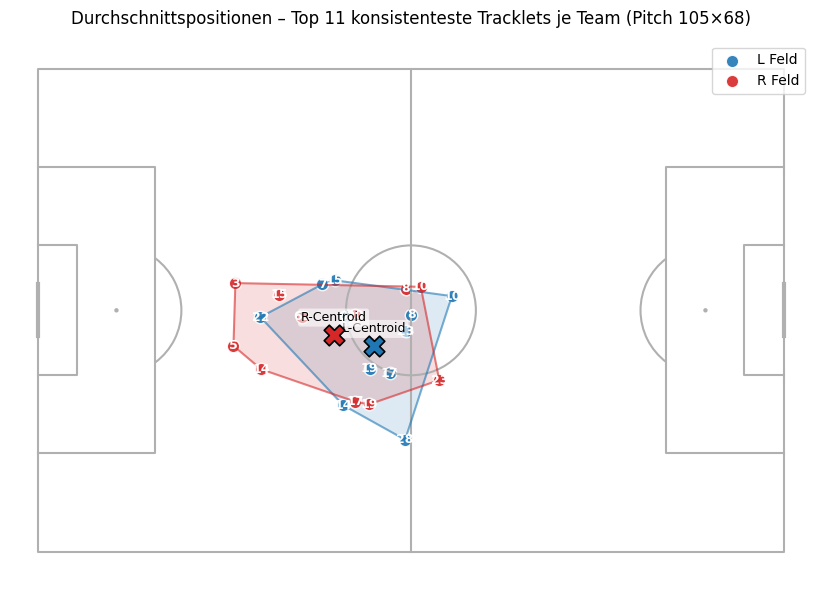

In [ ]:
# === Durchschnittspositionen & Auswahl der 11 konsistentesten je Team ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from IPython.display import display

# Voraussetzungen
assert 'players_speedfiltered' in globals(), "players_speedfiltered fehlt."
PITCH_LENGTH = globals().get('PITCH_LENGTH', 105)
PITCH_WIDTH  = globals().get('PITCH_WIDTH', 68)
FRAME_BREAK  = globals().get('FRAME_BREAK', 250)  # für „große Lücken“-Strafe
N_PER_TEAM   = 11

PLAYER_CLASSES = {"L", "R",}
TEAM_MAP = {"L":"L", "GK-L":"L", "R":"R", "GK-R":"R"}

df = (players_speedfiltered
      [players_speedfiltered['class'].isin(PLAYER_CLASSES)]
      .dropna(subset=['model_x','model_y','frame'])
      .copy())

# Teamspalte hinzufügen (GK-L/R -> L/R)
df['team'] = df['class'].map(TEAM_MAP)

# --- Tracklet-Zusammenfassung je (id,class,jersey) ---
def summarize_tracklet(g: pd.DataFrame) -> pd.Series:
    # Nur einzigartige, sortierte Frames für Vollständigkeit/Gaps
    frames = np.sort(g['frame'].astype(int).unique())
    n_frames = frames.size
    frame_min = int(frames[0])
    frame_max = int(frames[-1])
    tspan = frame_max - frame_min + 1
    completeness = float(n_frames / tspan) if tspan > 0 else 0.0

    gaps_big = int(np.sum(np.diff(frames) > FRAME_BREAK))

    return pd.Series({
        'team': g['team'].iloc[0],
        'mean_x': g['model_x'].mean(),
        'mean_y': g['model_y'].mean(),
        'n_frames': n_frames,
        'frame_min': frame_min,
        'frame_max': frame_max,
        'tspan': tspan,
        'completeness': completeness,
        'gaps_big': gaps_big,
        # Marker ob Keeper (für Plot)
        'is_gk': 1 if g['class'].iloc[0].startswith('GK') else 0,
    })

tracklet_summary = (df
    .groupby(['id','class','jersey'], as_index=False)
    .apply(summarize_tracklet)
    .reset_index(drop=True)
)

# --- Ranking nach „Konsistenz“ ---
# 1) höchste Vollständigkeit (completeness)  2) viele Frames  3) wenige große Lücken
tracklet_summary_sorted = (tracklet_summary
    .sort_values(['team','completeness','n_frames','gaps_big'],
                 ascending=[True, False, False, True])
)

# --- Top N je Team (Standard: 11) auswählen ---
topN = (tracklet_summary_sorted
        .groupby('team', group_keys=False)
        .head(N_PER_TEAM)
        .reset_index(drop=True))

# Ergebnis-DF für weitere Arbeit: Durchschnittspositionen der ausgewählten Tracklets
players_avgpos_selected = topN[['team','id','class','jersey','mean_x','mean_y','n_frames','completeness','gaps_big','is_gk']].copy()

# --- Team-Centroids (Durchschnitt der Tracklet-Mittel) ---
# ungewichtet:
team_centroids = (players_avgpos_selected
                  .groupby('team', as_index=False)
                  .agg(mean_x=('mean_x','mean'),
                       mean_y=('mean_y','mean'),
                       n_tracklets=('id','count')))

# gewichtet nach n_frames (robuster, wenn einige viel länger erfasst wurden):
def wavg(x, w): return (x*w).sum() / w.sum() if w.sum() > 0 else np.nan
team_centroids_weighted = (players_avgpos_selected
                           .groupby('team')
                           .apply(lambda g: pd.Series({
                               'mean_x_w': wavg(g['mean_x'], g['n_frames']),
                               'mean_y_w': wavg(g['mean_y'], g['n_frames']),
                               'sum_frames': int(g['n_frames'].sum()),
                               'n_tracklets': int(len(g))
                           }))
                           .reset_index())

# --- Helper: Konvexe Hülle (Monotone Chain, ohne Dependencies) ---
def convex_hull_xy(points: np.ndarray):
    """points: array Nx2 (x,y). Return hull as array Mx2 in Reihenfolge (geschlossen ohne Wiederholung)."""
    pts = np.asarray(points, dtype=float)
    if pts.shape[0] < 3:
        return None
    # Duplikate entfernen, nach x dann y sortieren
    pts = np.unique(pts, axis=0)
    if pts.shape[0] < 3:
        return None
    pts = pts[np.lexsort((pts[:,1], pts[:,0]))]

    def cross(o, a, b):
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])

    # untere Kette
    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    # obere Kette
    upper = []
    for p in pts[::-1]:
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    hull = np.vstack([lower[:-1], upper[:-1]])
    return hull if hull.shape[0] >= 3 else None

print("Ausgewählte Tracklets je Team:")
display(players_avgpos_selected.sort_values(['team','is_gk','jersey']).reset_index(drop=True))

print("\nTeam-Centroids (ungewichtet):")
display(team_centroids)

print("\nTeam-Centroids (gewichtet nach n_frames):")
display(team_centroids_weighted)

# --- Visualisierung auf Pitch ---
pitch = Pitch(pitch_type='custom', pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH,
              line_zorder=2, linewidth=1.5)
fig, ax = pitch.draw(figsize=(9, 6))

# Farben/Marker
COL = {'L':'tab:blue', 'R':'tab:red'}
MK_PLAYER = 'o'
MK_GK = 's'

# --- Konvexe Hülle je Team (Formation) ---
for team, grp in players_avgpos_selected.groupby('team'):
    pts = grp[['mean_x','mean_y']].to_numpy()
    hull = convex_hull_xy(pts)
    if hull is not None:
        ax.fill(hull[:,0], hull[:,1],
                color={'L':'tab:blue','R':'tab:red'}.get(team, 'k'),
                alpha=0.15, zorder=1, linewidth=0)
        ax.plot(np.r_[hull[:,0], hull[0,0]], np.r_[hull[:,1], hull[0,1]],
                color={'L':'tab:blue','R':'tab:red'}.get(team, 'k'),
                alpha=0.6, linewidth=1.5, zorder=2)

for team, grp in players_avgpos_selected.groupby('team'):
    c = COL.get(team, 'k')
    # Spielerpunkte
    gk_mask = grp['is_gk'] == 1
    # Feldspieler
    ax.scatter(grp.loc[~gk_mask, 'mean_x'], grp.loc[~gk_mask, 'mean_y'],
               s=80, marker=MK_PLAYER, edgecolors='white', linewidths=1.0, color=c, alpha=0.9, label=f"{team} Feld")
    # Keeper
    if gk_mask.any():
        ax.scatter(grp.loc[gk_mask, 'mean_x'], grp.loc[gk_mask, 'mean_y'],
                   s=110, marker=MK_GK, edgecolors='white', linewidths=1.2, color=c, alpha=0.95, label=f"{team} GK")
    # Labels: Jersey (Fallback: ID)
    labels = grp.apply(lambda r: str(int(r['jersey'])) if pd.notna(r['jersey']) and int(r['jersey'])>=0 else f"ID{int(r['id'])}", axis=1)
    for (_, r), lab in zip(grp.iterrows(), labels):
        ax.text(r['mean_x'], r['mean_y'], lab, ha='center', va='center',
                color='white', fontsize=9, fontweight='bold')

# Team-Centroids einzeichnen (gewichtet)
for _, row in team_centroids_weighted.iterrows():
    t = row['team']
    ax.scatter(row['mean_x_w'], row['mean_y_w'], s=220, marker='X',
               color=COL.get(t,'k'), edgecolors='black', linewidths=1.2, zorder=5)
    ax.text(row['mean_x_w'], row['mean_y_w']+1.5, f"{t}-Centroid", ha='center', va='bottom',
            fontsize=9, color='black', bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6, ec='none'))

ax.set_title(f"Durchschnittspositionen – Top {N_PER_TEAM} konsistenteste Tracklets je Team (Pitch {PITCH_LENGTH}×{PITCH_WIDTH})", pad=12)
# Legende kompakt
handles, labels = ax.get_legend_handles_labels()
bylabel = dict(zip(labels, handles))
ax.legend(bylabel.values(), bylabel.keys(), loc='upper right', frameon=True)

plt.show()


/var/folders/vj/dlhxjlvn3tg58344lkyywbx40000gn/T/ipykernel_3723/6367462.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frame_sigma  = df.groupby('frame').apply(_frame_sigma).rename('sigma')


TEAM=R | Samples: 35604 | Cluster K=2 | Top-N: 10


,frame,cluster,nx_1,ny_1,nx_2,ny_2,nx_3,ny_3,nx_4,ny_4,...,nx_6,ny_6,nx_7,ny_7,nx_8,ny_8,nx_9,ny_9,nx_10,ny_10
0,889,2,-0.330473,0.622353,-0.295969,0.054027,0.261026,0.327992,0.696941,0.805574,...,0.024388,-0.315334,-0.460207,0.395027,-0.040135,-0.525633,-0.236734,-1.200601,-0.094833,0.13256
1,890,2,-0.330473,0.622353,-0.295969,0.054027,0.261026,0.327992,0.696541,0.804157,...,0.024388,-0.315334,-0.463513,0.396571,-0.040135,-0.525633,-0.233028,-1.200728,-0.094833,0.13256
2,891,2,-0.330473,0.622353,-0.295969,0.054027,0.261026,0.327992,0.696467,0.803550,...,0.024388,-0.315334,-0.468173,0.396689,-0.040135,-0.525633,-0.228294,-1.200240,-0.094833,0.13256
3,892,2,-0.330473,0.622353,-0.295969,0.054027,0.261026,0.327992,0.696975,0.803461,...,0.024388,-0.315334,-0.473807,0.395642,-0.040135,-0.525633,-0.223168,-1.199103,-0.094833,0.13256
4,893,2,-0.330473,0.622353,-0.295969,0.054027,0.261026,0.327992,0.696444,0.804133,...,0.024388,-0.315334,-0.477109,0.394576,-0.040135,-0.525633,-0.219335,-1.198709,-0.094833,0.13256


Transitions (counts):


to,1,2
from,,
1,18312,173
2,174,16944


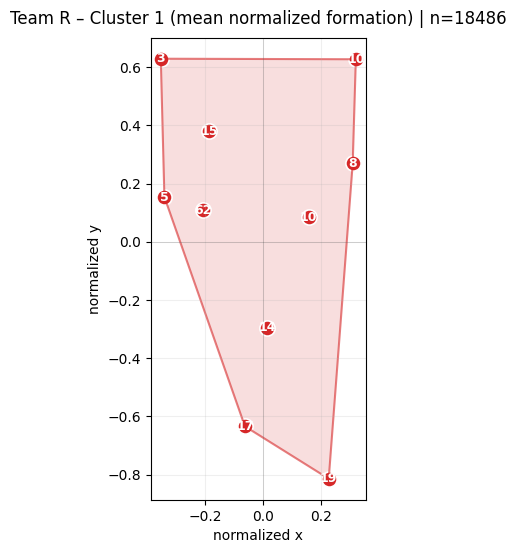

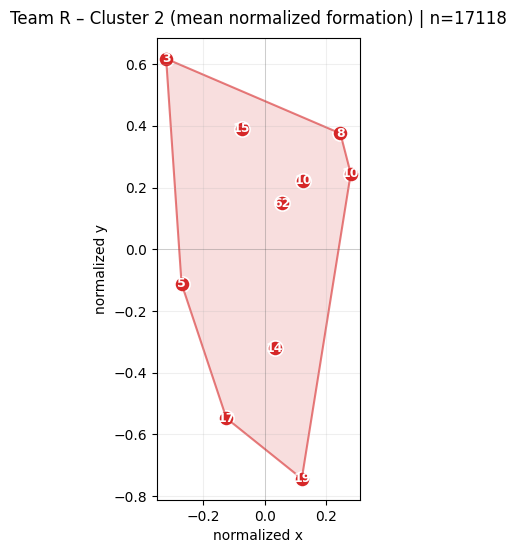

In [18]:
# === Narizuka & Yamazaki: Formations-Clustering mit Imputation ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------- Parameter -------------------------------------------
TEAM = 'R'          # 'L' oder 'R'
TOP_N = 10          # Anzahl Outfield-Tracklets (Torwart typischerweise ausgeschlossen)
STEP_FRAMES = 1    # Samplingabstand in Frames (~1s bei 25 FPS)
MIN_PRESENT = 3    # Mindestanzahl der TOP_N, die im Frame sichtbar sein müssen, um c/sigma stabil zu schätzen

# Pitch (wird hier nur informativ genutzt; clustering läuft in normalisierten Koords)
PITCH_LENGTH = globals().get('PITCH_LENGTH', 105.0)
PITCH_WIDTH  = globals().get('PITCH_WIDTH',  68.0)

assert 'players_speedfiltered' in globals(), "players_speedfiltered fehlt."

# ------------------------- Helpers ---------------------------------------------
def _normalize_xy(X: np.ndarray):
    """
    X: (N,2). Gibt (X - centroid) / sigma zurück, wobei
    sigma = sqrt(mean(||x_i - centroid||^2)).
    """
    if X.size == 0:
        return None
    c = X.mean(axis=0)
    Xc = X - c
    sig = np.sqrt((Xc**2).sum(axis=1).mean())
    if not np.isfinite(sig) or sig < 1e-6:
        return None
    return Xc / sig

def _adjacency_from_points(X: np.ndarray, try_delaunay=True, knn_k=3):
    """
    Erzeuge symmetrische 0/1-Adjazenz (N,N) aus Punkten X.
    Bevorzugt Delaunay, Fallback: symmetrisiertes kNN (k=3).
    """
    N = len(X)
    A = np.zeros((N, N), dtype=np.uint8)
    if try_delaunay:
        try:
            from scipy.spatial import Delaunay
            tri = Delaunay(X)  # (N,2)
            for simplex in tri.simplices:
                for i in range(3):
                    a = simplex[i]; b = simplex[(i+1) % 3]
                    A[a, b] = 1; A[b, a] = 1
        except Exception:
            try_delaunay = False
    if not try_delaunay:
        D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=-1)
        np.fill_diagonal(D, np.inf)
        for i in range(N):
            nn = np.argsort(D[i])[:knn_k]
            A[i, nn] = 1
        A = np.maximum(A, A.T)
    np.fill_diagonal(A, 0)
    return A

def _upper_vector(A: np.ndarray):
    """Obere Dreiecksmatrix (ohne Diagonale) als 1D-Feature-Vektor."""
    iu = np.triu_indices_from(A, k=1)
    return A[iu].astype(np.float32)

def _ward_linkage(features: np.ndarray):
    """
    Ward-Clustering. Gibt (labels, Z_or_None) zurück.
    - Mit SciPy: linkage + fcluster (Clusterzahl heuristisch).
    - Ohne SciPy: sklearn AgglomerativeClustering (Ward).
    """
    N_CLUSTERS = min(2, max(2, int(np.sqrt(len(features)))))  # einfache Heuristik
    try:
        from scipy.cluster.hierarchy import linkage, fcluster
        Z = linkage(features, method='ward', metric='euclidean')
        labels = fcluster(Z, t=N_CLUSTERS, criterion='maxclust')
        return labels.astype(int), Z
    except Exception:
        try:
            from sklearn.cluster import AgglomerativeClustering
            ac = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='ward')
            labels = ac.fit_predict(features) + 1  # 1..K
            return labels.astype(int), None
        except Exception as e:
            raise RuntimeError("Weder SciPy noch sklearn für Ward-Clustering verfügbar.") from e

def _frame_sigma(g: pd.DataFrame) -> float:
    """sigma pro Frame (wie in der Normalisierung): sqrt(mean(||x - c||^2))."""
    cx, cy = g['model_x'].mean(), g['model_y'].mean()
    d = g[['model_x','model_y']].to_numpy() - np.array([cx, cy])
    return float(np.sqrt((d**2).sum(axis=1).mean()))

def _convex_hull_xy(points: np.ndarray):
    """Konvexe Hülle (Monotone Chain). Rückgabe Mx2 oder None."""
    pts = np.asarray(points, float)
    if pts.shape[0] < 3:
        return None
    pts = np.unique(pts, axis=0)
    if pts.shape[0] < 3:
        return None
    pts = pts[np.lexsort((pts[:,1], pts[:,0]))]
    def cross(o,a,b): return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])
    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    upper = []
    for p in pts[::-1]:
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    hull = np.vstack([lower[:-1], upper[:-1]])
    return hull if hull.shape[0] >= 3 else None

# ------------------------- 1) Team filtern & ORDER bestimmen --------------------
df = players_speedfiltered.copy()
df = df[(df['class'] == TEAM)].dropna(subset=['frame','id','model_x','model_y']).copy()

# jersey robust behandeln (fehlende -> -1), id integer
df['jersey'] = df['jersey'].fillna(-1).astype(int)
df['id'] = df['id'].astype(int)
df['frame'] = df['frame'].astype(int)

# Aggregiere auf EINEN Punkt pro (frame,id,jersey) (Median), um Duplikate zu vermeiden
df = (df.groupby(['frame','id','jersey'], as_index=False)
        .agg(model_x=('model_x','median'),
             model_y=('model_y','median')))

# Top-N Tracklets nach Frame-Abdeckung
cover = (df.groupby(['id','jersey'])['frame']
           .nunique()
           .sort_values(ascending=False)
           .reset_index(name='n_frames'))
top = cover.head(TOP_N)
if len(top) < TOP_N:
    print(f"Warnung: nur {len(top)} Tracklets für Team {TEAM} gefunden (gefunden={len(top)}).")
# feste Reihenfolge über Zeit (erst jersey, dann id) – wie Rollenindex
ORDER = (top.sort_values(['jersey','id'])
            [['id','jersey']]
            .apply(tuple, axis=1)
            .tolist())

# ------------------------- 2) Frame-Stats & Anker (μ_i) im Normalraum ----------
# Frame-Zentrum/-sigma aus ALLEN im Frame sichtbaren Teamspielern (robust)
frame_center = df.groupby('frame').agg(mx=('model_x','mean'),
                                       my=('model_y','mean'))
frame_sigma  = df.groupby('frame').apply(_frame_sigma).rename('sigma')
frame_stats  = frame_center.join(frame_sigma)  # Index: frame

# Anker μ_i je ORDER-Spieler: Mittel der normalisierten Koords über seine Frames
anchors_norm = {}
for (tid, jer) in ORDER:
    sub = df[(df['id'] == tid) & (df['jersey'] == jer)][['frame','model_x','model_y']].copy()
    if sub.empty:
        anchors_norm[(tid, jer)] = np.zeros(2, dtype=float)
        continue
    sub = sub.merge(frame_stats, left_on='frame', right_index=True, how='left')
    m = sub['sigma'].to_numpy(dtype=float)
    valid = np.isfinite(m) & (m > 1e-6)
    if not valid.any():
        anchors_norm[(tid, jer)] = np.zeros(2, dtype=float)
    else:
        xn = (sub.loc[valid, 'model_x'].to_numpy() - sub.loc[valid, 'mx'].to_numpy()) / m[valid]
        yn = (sub.loc[valid, 'model_y'].to_numpy() - sub.loc[valid, 'my'].to_numpy()) / m[valid]
        anchors_norm[(tid, jer)] = np.array([xn.mean(), yn.mean()], dtype=float)

# ------------------------- 3) Sampling + Imputation ----------------------------
# MultiIndex-Table für schnellen Zugriff
dfw = (df.set_index(['frame','id','jersey'])[['model_x','model_y']].sort_index())

frames_all = np.array(sorted({f for f, _, _ in dfw.index}))
frames_sample = frames_all[::STEP_FRAMES]

samples, feat_vecs = [], []

for f in frames_sample:
    # Welche ORDER-Spieler sind in diesem Frame sichtbar?
    try:
        present_idx = set(dfw.loc[f].index)  # Menge von (id, jersey)
    except KeyError:
        continue

    # Sammle vorhandene ORDER-Punkte für c/sigma dieses Frames
    pts_present = []
    for key in ORDER:
        if key in present_idx:
            vals = dfw.loc[(f, key[0], key[1])]
            if isinstance(vals, pd.Series):
                x, y = float(vals.iloc[0]), float(vals.iloc[1])
            else:
                # falls mehrere Zeilen – nimm erste
                x, y = float(vals.iloc[0, 0]), float(vals.iloc[0, 1])
            pts_present.append((x, y))

    if len(pts_present) < MIN_PRESENT:
        continue

    pts_present = np.asarray(pts_present, dtype=float)

    # c/sigma: bevorzugt globale frame_stats, sonst aus den vorhandenen ORDER-Punkten
    if f in frame_stats.index and np.isfinite(frame_stats.loc[f, 'sigma']) and frame_stats.loc[f, 'sigma'] > 1e-6:
        cx, cy, sig = float(frame_stats.loc[f, 'mx']), float(frame_stats.loc[f, 'my']), float(frame_stats.loc[f, 'sigma'])
    else:
        cx, cy = pts_present.mean(axis=0)
        d = pts_present - np.array([cx, cy])
        sig = float(np.sqrt((d**2).sum(axis=1).mean()))
        if not np.isfinite(sig) or sig < 1e-6:
            continue

    # Vollständige normalisierte Matrix Xn (N=TOP_N)
    Xn = np.zeros((len(ORDER), 2), dtype=float)
    for i, key in enumerate(ORDER):
        if key in present_idx:
            vals = dfw.loc[(f, key[0], key[1])]
            if isinstance(vals, pd.Series):
                x, y = float(vals.iloc[0]), float(vals.iloc[1])
            else:
                x, y = float(vals.iloc[0, 0]), float(vals.iloc[0, 1])
            Xn[i, 0] = (x - cx) / sig
            Xn[i, 1] = (y - cy) / sig
        else:
            # Imputation im Normalraum mit Rollen-Anker μ_i
            Xn[i, :] = anchors_norm.get(key, np.zeros(2, dtype=float))

    # Adjazenz und Feature-Vektor
    A = _adjacency_from_points(Xn, try_delaunay=True, knn_k=3)
    v = _upper_vector(A)
    samples.append({'frame': int(f), 'Xn': Xn, 'A': A, 'vec': v})
    feat_vecs.append(v)

if not samples:
    raise ValueError("Keine gültigen Samples nach Imputation – prüfe MIN_PRESENT/STEP_FRAMES/ORDER.")

features = np.vstack(feat_vecs)  # (S, P)

# ------------------------- 4) Ward-Clustering ----------------------------------
labels, Z = _ward_linkage(features)  # labels: 1..K
labels = labels.astype(int)
K = int(labels.max())

# ------------------------- 5) Ergebnisse strukturieren -------------------------
cols_nx = [f"nx_{i+1}" for i in range(len(ORDER))]
cols_ny = [f"ny_{i+1}" for i in range(len(ORDER))]
rows = []
for s, lab in zip(samples, labels):
    rec = {'frame': s['frame'], 'cluster': int(lab)}
    Xn = s['Xn']
    for i in range(len(ORDER)):
        rec[cols_nx[i]] = float(Xn[i,0])
        rec[cols_ny[i]] = float(Xn[i,1])
    rows.append(rec)

formation_samples = pd.DataFrame(rows).sort_values('frame').reset_index(drop=True)

# Transition-Matrix (Cluster -> nächster Cluster)
if len(formation_samples) >= 2:
    c = formation_samples['cluster'].to_numpy()
    transitions = pd.crosstab(c[:-1], c[1:], rownames=['from'], colnames=['to'])
else:
    transitions = pd.DataFrame()

print(f"TEAM={TEAM} | Samples: {len(formation_samples)} | Cluster K={K} | Top-N: {len(ORDER)}")
display(formation_samples.head())
print("Transitions (counts):")
display(transitions)

# ------------------------- 6) Plot-Helfer: mittlere Formation je Cluster -------
def plot_cluster_formation(cluster_id: int, use_hull: bool=True):
    """
    Zeichnet die mittlere normierte Formation (über alle Samples des Clusters).
    Reihenfolge der Punkte entspricht ORDER (sortiert nach jersey,id).
    """
    sub = formation_samples[formation_samples['cluster'] == cluster_id]
    if sub.empty:
        print(f"Cluster {cluster_id}: keine Samples.")
        return

    Xmean = np.column_stack([sub[cols_nx].mean().to_numpy(),
                             sub[cols_ny].mean().to_numpy()])

    fig, ax = plt.subplots(figsize=(7, 6))
    color = 'tab:blue' if TEAM=='L' else 'tab:red'
    ax.scatter(Xmean[:,0], Xmean[:,1], s=120, color=color, edgecolors='white', linewidths=1.2)

    # Labels: jersey (Fallback ID)
    for i, (tid, jer) in enumerate(ORDER):
        lab = str(int(jer)) if int(jer) >= 0 else f"ID{int(tid)}"
        ax.text(Xmean[i,0], Xmean[i,1], lab, ha='center', va='center',
                color='white', fontsize=9, fontweight='bold')

    if use_hull and Xmean.shape[0] >= 3:
        H = _convex_hull_xy(Xmean)
        if H is not None:
            ax.fill(H[:,0], H[:,1], color=color, alpha=0.15, zorder=0, linewidth=0)
            ax.plot(np.r_[H[:,0], H[0,0]], np.r_[H[:,1], H[0,1]],
                    color=color, alpha=0.6, linewidth=1.5, zorder=1)

    ax.set_title(f"Team {TEAM} – Cluster {cluster_id} (mean normalized formation) | n={len(sub)}", pad=10)
    ax.axhline(0, color='k', lw=0.5, alpha=0.2); ax.axvline(0, color='k', lw=0.5, alpha=0.2)
    ax.set_xlabel("normalized x"); ax.set_ylabel("normalized y")
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, alpha=0.2)
    plt.show()

# Beispiel: alle Cluster plotten
for cid in range(1, K+1):
    plot_cluster_formation(cid)

# ------------------------- 7) Ergebnisse für spätere Nutzung --------------------
FORMATION_RESULTS = {
    'TEAM': TEAM,
    'ORDER': ORDER,                       # Reihenfolge (id, jersey)
    'anchors_norm': anchors_norm,         # μ_i pro Spieler im Normalraum
    'samples': formation_samples,         # frame, cluster, nx_i, ny_i
    'transitions': transitions,           # Übergangszahlen
    'linkage': 'SciPy' if 'Z' in locals() and Z is not None else 'sklearn',
}


In [ ]:
# === Formation aus Clustern ableiten (Linienstärken entlang x) =================
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

assert 'FORMATION_RESULTS' in globals() and 'formation_samples' in globals(), \
    "Bitte zuerst die Formations-Clustering-Zelle ausführen."

samples = formation_samples.copy()
ORDER   = FORMATION_RESULTS['ORDER']
TEAM    = FORMATION_RESULTS['TEAM']

# Kandidaten-Formationen (Back -> Front), Summe = 10 Outfield
CANDIDATES = {
    3: {
        (4,4,2): "4-4-2",
        (4,3,3): "4-3-3",
        (5,3,2): "5-3-2",
        (3,5,2): "3-5-2",
        (3,4,3): "3-4-3",
        (5,4,1): "5-4-1",
        (4,5,1): "4-5-1",
    },
    4: {
        (4,2,3,1): "4-2-3-1",
        (4,1,4,1): "4-1-4-1",
        (3,4,2,1): "3-4-2-1",
        (5,2,2,1): "5-2-2-1",
        (4,3,1,2): "4-3-1-2",
        (4,4,1,1): "4-4-1-1",
        (4,2,2,2): "4-2-2-2",
    },
}

K_RANGE = [3, 4]

def _classify_formation_for_cluster(df_cluster: pd.DataFrame):
    """df_cluster: alle Zeilen eines Clusters aus formation_samples."""
    N = len(ORDER)  # normalerweise 10
    # Mittel der normalisierten Koords (nx_i, ny_i)
    x = df_cluster[[f"nx_{i+1}" for i in range(N)]].mean().to_numpy(float)
    # Angriffsrichtung vereinheitlichen: Front positiv
    if np.nanmean(x) < 0:
        x = -x

    results = []
    n = len(x)
    for K in K_RANGE:
        if K > n:
            continue
        km = KMeans(n_clusters=K, n_init=20, random_state=0)
        labels = km.fit_predict(x.reshape(-1,1))
        centers = km.cluster_centers_.ravel()
        # Zentren sortieren (back->front), Labels reindizieren
        order = np.argsort(centers)
        remap = {old:new for new, old in enumerate(order)}
        labels_ord = np.vectorize(remap.get)(labels)
        centers_ord = np.sort(centers)

        # Linienstärken (back->front)
        counts = tuple(int(np.sum(labels_ord==k)) for k in range(K))

        # Within-Cluster SSE
        sse = float(np.sum((x - centers_ord[labels_ord])**2))

        # einfache BIC-Heuristik (K penalisiert)
        # BIC ~ n*ln(SSE/n) + K*ln(n); robust gegen skalenverschiebung
        if sse <= 1e-12:
            bic = -np.inf
        else:
            bic = n*np.log(sse/n) + K*np.log(n)

        results.append({
            'K': K,
            'counts': counts,
            'centers': centers_ord,
            'labels': labels_ord,
            'sse': sse,
            'bic': bic,
        })

    if not results:
        return {'name': None, 'counts': None, 'K': None, 'centers': None}

    # bestes K nach BIC
    best = min(results, key=lambda r: r['bic'])

    # Kandidaten-Mapping
    name = None
    if best['K'] in CANDIDATES and best['counts'] in CANDIDATES[best['K']]:
        name = CANDIDATES[best['K']][best['counts']]
    else:
        # geringste L1-Distanz zu bekannten (gleiche K)
        if best['K'] in CANDIDATES:
            cand_all = list(CANDIDATES[best['K']].keys())
            cand = [c for c in cand_all if len(c) == len(best['counts'])]
            if cand:
                d = [np.sum(np.abs(np.array(best['counts']) - np.array(c))) for c in cand]
                j = int(np.argmin(d))
                name = CANDIDATES[best['K']][cand[j]] + " (nearest)"
            else:
                name = None

    return {
        'name': name,
        'counts': best['counts'],   # Back->Front
        'K': best['K'],
        'centers': best['centers'], # Back->Front (x in Normalraum)
    }

# ==== Anwendung auf alle Cluster ====
out_rows = []
for cid, sub in samples.groupby('cluster'):
    info = _classify_formation_for_cluster(sub)
    out_rows.append({
        'cluster': int(cid),
        'formation': info['name'],
        'lines': info['counts'],
        'K': info['K'],
        'centers_x(back->front)': np.round(info['centers'], 3) if info['centers'] is not None else None,
        'n_samples': len(sub),
    })

formation_summary = pd.DataFrame(out_rows).sort_values('cluster').reset_index(drop=True)
print(f"Team {TEAM} – automatische Formationsklassifikation pro Cluster")
display(formation_summary)

# klare Benennung auch in formation_samples mitschreiben
formation_map = {row['cluster']: row['formation'] for _, row in formation_summary.iterrows()}
samples['formation_guess'] = samples['cluster'].map(formation_map)


Team R – automatische Formationsklassifikation pro Cluster


,cluster,formation,lines,K,centers_x(back->front),n_samples
0,1,4-2-2-2,"(4, 2, 2, 2)",4,"[-0.252, 0.025, 0.196, 0.345]",18486
1,2,4-2-3-1 (nearest),"(2, 2, 4, 2)",4,"[-0.295, -0.1, 0.083, 0.262]",17118


EM Iteration 01: Mittel-Verschiebung = 11.7711, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 02: Mittel-Verschiebung = 1.2386, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 03: Mittel-Verschiebung = 0.8004, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 04: Mittel-Verschiebung = 0.5792, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 05: Mittel-Verschiebung = 0.4786, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 06: Mittel-Verschiebung = 0.4525, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 07: Mittel-Verschiebung = 0.8578, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 08: Mittel-Verschiebung = 1.3070, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 09: Mittel-Verschiebung = 0.5695, Rollenbeobachtungen min/median/max = 4375/4375.0/4375
EM Iteration 10: Mittel-Verschiebung = 0.2488, Rollenbeobachtungen min/median/max = 4375/4

,role,mu_x,mu_y,cov_xx,cov_xy,cov_yy,n_frames
0,4,1.986960,-13.184478,18.334393,-13.150016,48.621781,4375
1,8,-5.434988,-9.305347,18.193146,2.836821,36.600906,4375
2,0,2.079211,-8.152113,6.548800,2.842359,14.099185,4375
3,6,6.715677,-4.976129,29.857359,-17.303830,19.262188,4375
4,3,-6.853724,-1.207537,25.945437,2.200174,18.651234,4375
5,7,0.278651,2.327224,10.239304,0.859551,8.566035,4375
6,1,6.831959,5.446491,28.733242,-0.380014,17.470774,4375
7,9,-5.167886,7.224806,45.494065,-8.490154,4.417220,4375
8,2,-4.314828,9.181538,16.726237,-7.886027,35.278625,4375
9,5,3.878967,12.645544,13.747826,15.779335,43.199387,4375



=== Beispiel-Mapping (erste 10 Zeilen) ===


,frame,role,id,jersey,x_centered,y_centered
0,2906,0,76,5,-5.988,-12.159
1,2906,1,156,-1,17.282,9.031
2,2906,2,147,-1,-8.388,11.281
3,2906,3,56,19,-15.438,-0.409
4,2906,4,77,17,5.802,-21.299
...,...,...,...,...,...,...
95,2915,5,157,-1,4.893,21.521
96,2915,6,155,-1,15.433,-12.279
97,2915,7,65,62,6.843,5.301
98,2915,8,146,-1,-6.587,-5.829


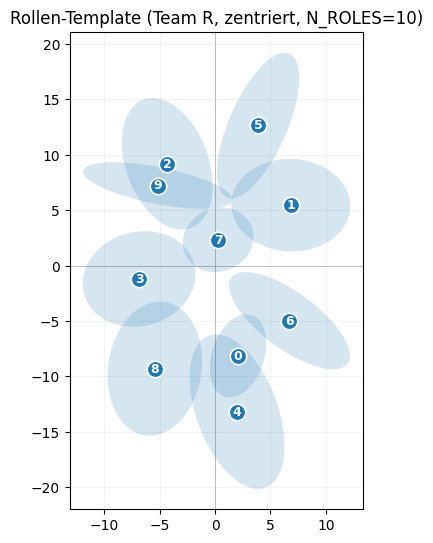


Objekte für spätere Nutzung: BIALKOWSKI_ROLES['roles_df'], ['role_mapping'], ['mu'], ['cov']


In [20]:
# === Rollen-Alignment nach Bialkowski (EM + Hungarian) auf Original-CSV =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------- Parameter -----------------------------------------
CSV_PATH = "PnLCalib/output/1_1_transformed.csv"  # <== Pfad bei Bedarf anpassen
TEAM = "R"                    # 'L' oder 'R'
USE_GK = False                # Torhüter mitnehmen? (für Outfield-Template False → 10 Rollen)
N_ROLES = 11 if USE_GK else 10
PITCH_LENGTH, PITCH_WIDTH = 105.0, 68.0
OFF_MARGIN = 3.0              # Meter Toleranz jenseits der Linien (wird entfernt)
SAMPLE_EVERY = 1              # jeden n-ten Frame für EM verwenden (Speed vs. Genauigkeit)
MAX_ITERS = 15                # EM-Iterationen
RIDGE = 0.10                  # Kovarianz-Regularisierung (λ * I)
RANDOM_STATE = 0              # Reproduzierbarkeit

# --------------------------- SciPy / KMeans ------------------------------------
try:
    from scipy.optimize import linear_sum_assignment
except Exception as e:
    raise RuntimeError("Diese Zelle benötigt SciPy (scipy.optimize.linear_sum_assignment).") from e

try:
    from sklearn.cluster import KMeans
    HAVE_KMEANS = True
except Exception:
    HAVE_KMEANS = False
    np.random.seed(RANDOM_STATE)

# --------------------------- CSV laden & Off-Pitch filtern ---------------------
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower() for c in df.columns]

needed = {"frame","id","model_x","model_y","class","jersey"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}. Gefunden: {list(df.columns)}")

# dtypes & Normalisierung
df["frame"]   = pd.to_numeric(df["frame"], errors="coerce").astype("Int64")
df["id"]      = pd.to_numeric(df["id"], errors="coerce").astype("Int64")
df["model_x"] = pd.to_numeric(df["model_x"], errors="coerce")
df["model_y"] = pd.to_numeric(df["model_y"], errors="coerce")
df["class"]   = df["class"].astype(str).str.strip().str.upper().str.replace("_","-", regex=False)
df["jersey"]  = pd.to_numeric(df["jersey"], errors="coerce").astype("Int64")

# Off-Pitch raus
xmin, xmax = -OFF_MARGIN, PITCH_LENGTH + OFF_MARGIN
ymin, ymax = -OFF_MARGIN, PITCH_WIDTH  + OFF_MARGIN
on_pitch = (df["model_x"].between(xmin, xmax)) & (df["model_y"].between(ymin, ymax))
df = df[on_pitch].dropna(subset=["frame","id","model_x","model_y"]).copy()

# Team-Filter
if USE_GK:
    team_mask = df["class"].isin([TEAM, f"GK-{TEAM}"])
else:
    team_mask = df["class"].isin([TEAM])  # nur Outfield dieses Teams
df = df[team_mask].copy()

# Duplikate pro (frame,id,jersey) robust mitteln (Median)
df["frame"] = df["frame"].astype(int)
df["id"]    = df["id"].astype(int)
df["jersey"] = df["jersey"].fillna(-1).astype(int)
df = (df.groupby(["frame","id","jersey"], as_index=False)
        .agg(model_x=("model_x","median"),
             model_y=("model_y","median")))

# --------------------------- Spielrichtung vereinheitlichen --------------------
# Heuristik: Steigt Team-Zentrum über die Zeit im Mittel nach rechts (x)? Falls nicht → flip.
g_cent = df.groupby("frame")[["model_x"]].mean().sort_index()
if len(g_cent) >= 2:
    x = g_cent.index.astype(float).to_numpy()
    y = g_cent["model_x"].to_numpy(float)
    slope = np.polyfit(x, y, 1)[0]
    if slope < 0:  # Richtung invertieren (rechtslauf erzwingen)
        df["model_x"] = PITCH_LENGTH - df["model_x"]

# --------------------------- Frames mit exakt N_ROLES Outfield -----------------
# (EM wird auf Frames mit vollständigem Set geschätzt; übrige Frames kann man später mappen)
counts = df.groupby("frame")["id"].nunique()
frames_ok = counts[counts == N_ROLES].index.to_numpy()
frames_ok = frames_ok[::max(1, SAMPLE_EVERY)]  # subsamplen
if len(frames_ok) == 0:
    raise ValueError(f"Keine Frames mit exakt N_ROLES={N_ROLES}. "
                     f"Prüfe TEAM/USE_GK/Off-Margin oder reduziere N_ROLES.")

# Für schnellen Zugriff: pro Frame die Liste (id, jersey, x, y)
frame_groups = df.set_index("frame").sort_index()
def get_frame_points(f):
    sub = frame_groups.loc[f]
    if isinstance(sub, pd.Series):  # nur ein Spieler (sollte nicht vorkommen nach Filter)
        sub = sub.to_frame().T
    # N_ROLES sicherstellen
    sub = sub.sort_values(["id","jersey"])
    pts = sub[["model_x","model_y"]].to_numpy(float)
    idx = sub[["id","jersey"]].apply(tuple, axis=1).tolist()
    return idx, pts

# --------------------------- Zentrierung pro Frame (Translation raus) ----------
def center_points(X):
    c = X.mean(axis=0)
    return X - c, c

# --------------------------- Initialisierung (KMeans oder zufällig) ------------
all_pts = []
for f in frames_ok:
    _, pts = get_frame_points(f)
    Xc, _ = center_points(pts)
    all_pts.append(Xc)
all_pts = np.vstack(all_pts)  # (S*N, 2)

if HAVE_KMEANS:
    km = KMeans(n_clusters=N_ROLES, n_init=20, random_state=RANDOM_STATE)
    km.fit(all_pts)
    mu = km.cluster_centers_.astype(float)                # (R,2)
else:
    # Zufällig aus Punkten ziehen
    ridx = np.random.choice(len(all_pts), size=N_ROLES, replace=False)
    mu = all_pts[ridx].astype(float)

# anfängliche isotrope Kovarianz
cov = np.stack([np.eye(2)*(all_pts.var(axis=0).mean() + 1e-3) for _ in range(N_ROLES)])  # (R,2,2)

# --------------------------- Helper: NLL-Kostenmatrix --------------------------
def nll_cost_matrix(X, mu, cov):
    """
    X: (N,2) Frame-zentriert; mu: (R,2); cov: (R,2,2)  -> C (R,N) mit NLLs
    Mahalanobis^2 + log|Σ| (ohne konst. 2π).
    """
    R, N = mu.shape[0], X.shape[0]
    C = np.zeros((R, N), dtype=float)
    for r in range(R):
        S = cov[r] + RIDGE * np.eye(2)
        try:
            L = np.linalg.cholesky(S)
            Linv = np.linalg.inv(L)
            logdet = 2*np.log(np.diag(L)).sum()
        except np.linalg.LinAlgError:
            Sinv = np.linalg.pinv(S)
            logdet = np.log(max(np.linalg.det(S), 1e-12))
            Linv = None
        for n in range(N):
            d = X[n] - mu[r]
            if Linv is not None:
                md2 = (Linv @ d) @ (Linv @ d)
            else:
                md2 = d @ (Sinv @ d)
            C[r, n] = md2 + logdet
    return C

# --------------------------- EM-Schleife ---------------------------------------
assignments = {}   # frame -> list of (role_idx, (id,jersey), x_cent, y_cent)
for it in range(1, MAX_ITERS+1):
    # E-Schritt: Zuordnen per Hungarian in jedem Frame
    assignments.clear()
    for f in frames_ok:
        idx, pts = get_frame_points(f)
        Xc, _ = center_points(pts)   # Translation entfernen
        C = nll_cost_matrix(Xc, mu, cov)  # (R,N)  R=N_ROLES, N=N_ROLES
        row_ind, col_ind = linear_sum_assignment(C)  # minimiert Summe C[r, n]
        # row_ind = roles, col_ind = spieler-index in diesem Frame
        pairings = []
        for r, n in zip(row_ind, col_ind):
            pairings.append((int(r), idx[n], Xc[n,0], Xc[n,1]))
        assignments[f] = pairings

    # M-Schritt: mu, cov aus den zugewiesenen Punkten neu schätzen
    new_mu = np.zeros_like(mu)
    new_cov = np.zeros_like(cov)
    counts_r = np.zeros(N_ROLES, dtype=int)

    for r in range(N_ROLES):
        pts_r = []
        for f, pairs in assignments.items():
            for (rr, _idjer, xc, yc) in pairs:
                if rr == r:
                    pts_r.append([xc, yc])
        if len(pts_r) == 0:
            # Rolle ohne Beobachtungen -> beibehalten
            new_mu[r] = mu[r]
            new_cov[r] = cov[r]
        else:
            pts_r = np.asarray(pts_r, dtype=float)
            new_mu[r] = pts_r.mean(axis=0)
            # numerisch stabil: Mindestvarianz
            if len(pts_r) >= 2:
                S = np.cov(pts_r.T)
            else:
                S = np.eye(2) * 0.25
            # leicht regularisieren
            new_cov[r] = S + RIDGE * np.eye(2)
            counts_r[r] = len(pts_r)

    # Konvergenz-Check (Verschiebung der Mittel)
    shift = float(np.linalg.norm(new_mu - mu))
    mu, cov = new_mu, new_cov
    print(f"EM Iteration {it:02d}: Mittel-Verschiebung = {shift:.4f}, Rollenbeobachtungen min/median/max = "
          f"{counts_r.min()}/{np.median(counts_r)}/{counts_r.max()}")
    if shift < 1e-3:
        break

# --------------------------- Ergebnisse aufbereiten -----------------------------
# 1) Rollen-Template (zentriert)
roles_df = pd.DataFrame({
    "role": np.arange(N_ROLES, dtype=int),
    "mu_x": mu[:,0],
    "mu_y": mu[:,1],
    "cov_xx": cov[:,0,0],
    "cov_xy": cov[:,0,1],
    "cov_yy": cov[:,1,1],
    "n_frames": [sum(1 for f in assignments for (rr, *_rest) in assignments[f] if rr==r) for r in range(N_ROLES)]
}).sort_values("mu_y").reset_index(drop=True)  # nach Höhe sortieren

# 2) Frame-weise Mapping-Tabelle (Rolle ↔ (id, jersey)) + zentrale Koords
rows = []
for f, pairs in sorted(assignments.items()):
    for (r, (pid, jer), xc, yc) in pairs:
        rows.append({
            "frame": f,
            "role": int(r),
            "id": int(pid),
            "jersey": int(jer),
            "x_centered": float(xc),
            "y_centered": float(yc),
        })
role_mapping = pd.DataFrame(rows).sort_values(["frame","role"]).reset_index(drop=True)

print("\n=== Rollen-Template (zentriert; Translation entfernt) ===")
display(roles_df)

print("\n=== Beispiel-Mapping (erste 10 Zeilen) ===")
display(role_mapping.head(100))

# --------------------------- Plot-Vorschau ---------------------------
try:
    from matplotlib.patches import Ellipse
    fig, ax = plt.subplots(figsize=(7.2, 6.2))
    ax.scatter(roles_df["mu_x"], roles_df["mu_y"], s=140, c="tab:blue",
               edgecolors="white", linewidths=1.2, zorder=3)
    for _, r in roles_df.iterrows():
        # 1σ-Ellipse aus Kovarianz
        cov_mat = np.array([[r["cov_xx"], r["cov_xy"]],[r["cov_xy"], r["cov_yy"]]])
        vals, vecs = np.linalg.eigh(cov_mat)
        vals = np.maximum(vals, 1e-6)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
        w, h = 2*np.sqrt(vals[0]), 2*np.sqrt(vals[1])
        e = Ellipse((r["mu_x"], r["mu_y"]), width=w, height=h, angle=angle,
                    facecolor="tab:blue", alpha=0.18, edgecolor="none", zorder=2)
        ax.add_patch(e)
        ax.text(r["mu_x"], r["mu_y"], str(int(r["role"])), color="white",
                ha="center", va="center", fontsize=9, fontweight="bold", zorder=4)
    ax.axhline(0, color="k", lw=0.6, alpha=0.25); ax.axvline(0, color="k", lw=0.6, alpha=0.25)
    ax.set_title(f"Rollen-Template (Team {TEAM}, zentriert, N_ROLES={N_ROLES})")
    ax.set_aspect("equal"); ax.grid(True, alpha=0.15)
    plt.show()
except Exception:
    pass

# --------------------------- Artefakte speichern für Folgezellen ----------------
BIALKOWSKI_ROLES = {
    "team": TEAM,
    "n_roles": N_ROLES,
    "mu": mu,              # (R,2) zentriert
    "cov": cov,            # (R,2,2)
    "roles_df": roles_df,  # DataFrame
    "role_mapping": role_mapping,  # DataFrame: frame,role,id,jersey,x_centered,y_centered
    "frames_used": np.array(sorted(assignments.keys()), dtype=int),
    "params": {
        "use_gk": USE_GK,
        "off_margin": OFF_MARGIN,
        "sample_every": SAMPLE_EVERY,
        "ridge": RIDGE,
        "iters": it
    }
}
print("\nObjekte für spätere Nutzung: BIALKOWSKI_ROLES['roles_df'], ['role_mapping'], ['mu'], ['cov']")


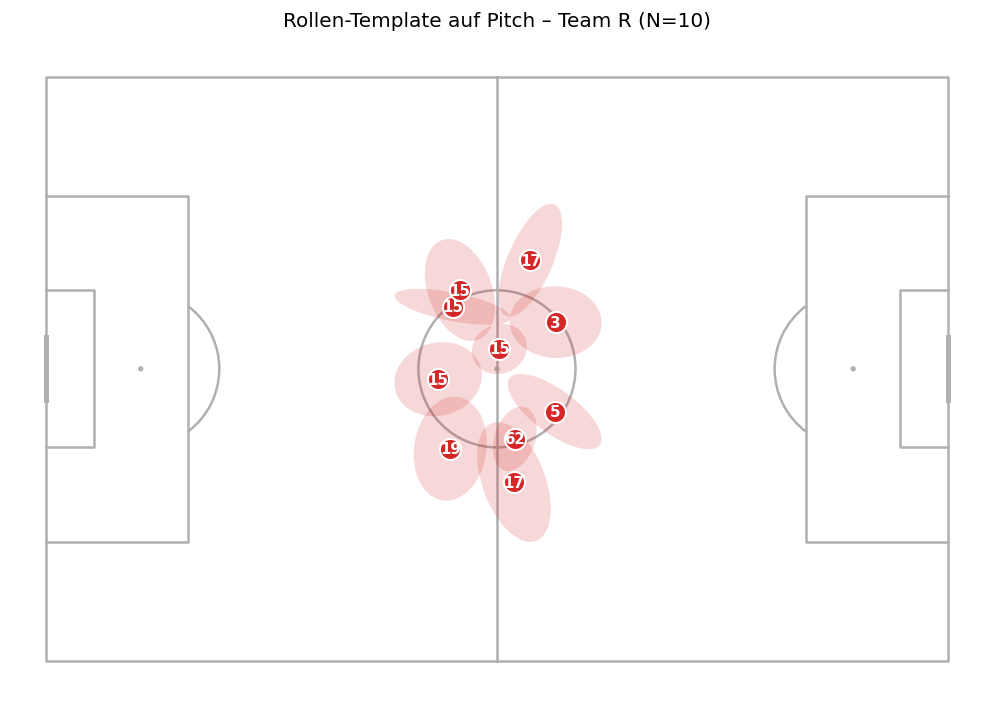

In [ ]:
# === Rollen-Template auf mplsoccer-Pitch zeichnen ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Ellipse

# Voraussetzungen
assert 'BIALKOWSKI_ROLES' in globals(), "Bitte zuerst die EM/Hungarian-Zelle ausführen (BIALKOWSKI_ROLES fehlt)."

# --- Parameter ---
PITCH_LENGTH = globals().get('PITCH_LENGTH', 105.0)
PITCH_WIDTH  = globals().get('PITCH_WIDTH', 68.0)
TEAM         = BIALKOWSKI_ROLES.get('team', 'L')
ELLIPSE_SIGMA = 1.0     # 1.0 = 1σ; 1.5-2.0 macht die Flächen „großzügiger“
POINT_SIZE     = 160
COLOR_TEAM     = 'tab:blue' if TEAM == 'L' else 'tab:red'
LABEL_MODE     = 'jersey_or_role'  # 'jersey_or_role' | 'role'

# Wo das zentrierte Template auf dem Pitch liegen soll (hier: Mittellinien-Zentrum)
CENTER_X = PITCH_LENGTH / 2.0
CENTER_Y = PITCH_WIDTH  / 2.0

# --- Daten aus Artefakten holen ---
roles_df    = BIALKOWSKI_ROLES['roles_df'].copy()   # Spalten: role, mu_x, mu_y, cov_xx, cov_xy, cov_yy, ...
role_map_df = BIALKOWSKI_ROLES['role_mapping'].copy()  # frame, role, id, jersey, x_centered, y_centered

jersey_mode = (
    role_map_df[role_map_df['jersey'] >= 0]
      .groupby('role')['jersey']
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else -1)
      .to_dict()
)

# Absolute (Pitch-)Koordinaten des Rollenmittelpunkts
roles_df['x_abs'] = roles_df['mu_x'] + CENTER_X
roles_df['y_abs'] = roles_df['mu_y'] + CENTER_Y

# --- Plot ---
pitch = Pitch(pitch_type='custom', pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH,
              line_zorder=2, linewidth=1.5)
fig, ax = pitch.draw(figsize=(9, 6))

# Ellipse-Helfer
def add_cov_ellipse(ax, x, y, cov_xx, cov_xy, cov_yy, k_sigma=1.0, **kwargs):
    cov = np.array([[cov_xx, cov_xy],[cov_xy, cov_yy]], dtype=float)
    vals, vecs = np.linalg.eigh(cov)
    vals = np.maximum(vals, 1e-9)  # numeric guard
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2 * k_sigma * np.sqrt(vals[0]), 2 * k_sigma * np.sqrt(vals[1])
    e = Ellipse((x, y), width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(e)

# Punkte + Ellipsen + Labels
for _, r in roles_df.iterrows():
    # Ellipse (1σ standard; Farbe leicht transparent)
    add_cov_ellipse(ax, r['x_abs'], r['y_abs'],
                    r['cov_xx'], r['cov_xy'], r['cov_yy'],
                    k_sigma=ELLIPSE_SIGMA,
                    facecolor=COLOR_TEAM, edgecolor='none', alpha=0.18, zorder=2)

    # Punkt
    ax.scatter(r['x_abs'], r['y_abs'], s=POINT_SIZE,
               color=COLOR_TEAM, edgecolors='white', linewidths=1.2, zorder=3)

    # Label
    if LABEL_MODE == 'jersey_or_role' and r['role'] in jersey_mode and jersey_mode[r['role']] >= 0:
        label = str(int(jersey_mode[r['role']]))
    else:
        label = str(int(r['role']))
    ax.text(r['x_abs'], r['y_abs'], label, ha='center', va='center',
            color='white', fontsize=9, fontweight='bold', zorder=4)

ax.set_title(f"Rollen-Template auf Pitch – Team {TEAM} (N={BIALKOWSKI_ROLES['n_roles']})", pad=10)
plt.show()


Linien (vorn→hinten): K=4, Counts=(2, 1, 3, 4)

Rollen → Positionskürzel (vorn→hinten, ohne Richtungs-Schätzung)


,role,position,jersey,x_abs,y_abs,line,n_obs
0,6,LS,5,78.389225,26.146928,0,4375
1,1,RS,3,78.505506,36.569547,0,4375
2,5,AM1,17,75.552514,43.768601,1,4375
3,4,LDM,17,73.660507,17.938578,2,4375
4,0,ZDM,62,73.752759,22.970944,2,4375
5,7,RDM,15,71.952199,33.450281,2,4375
6,8,LV,19,66.238560,21.817710,3,4375
7,3,IV,15,64.819824,29.915520,3,4375
8,9,IV,15,66.505662,38.347863,3,4375
9,2,RV,15,67.358720,40.304594,3,4375


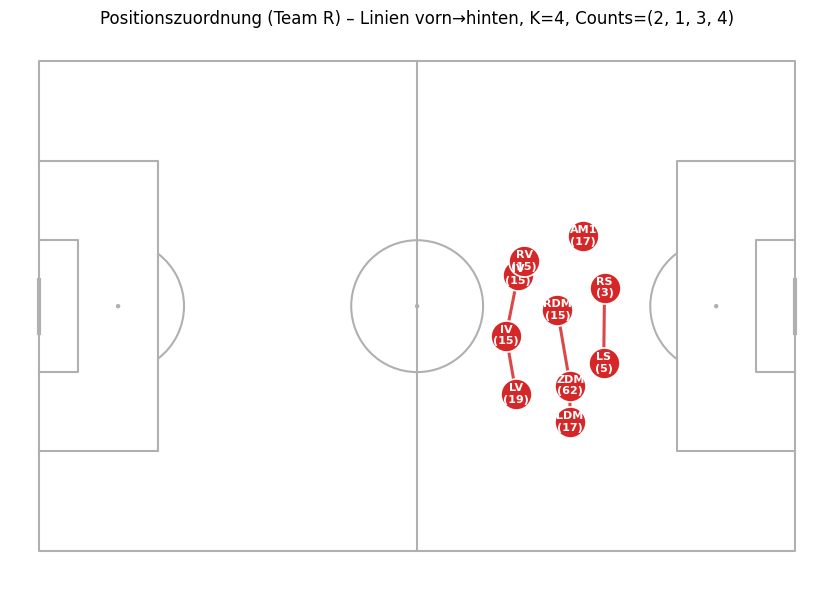

In [ ]:
# === Rollen → Positionskürzel (umgedrehte Linien) + Linien zeichnen =============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Voraussetzungen
assert 'BIALKOWSKI_ROLES' in globals() and 'df' in globals(), \
    "Bitte vorher die EM/Hungarian-Zelle ausführen (liefert BIALKOWSKI_ROLES und df)."

PITCH_LENGTH = globals().get('PITCH_LENGTH', 105.0)
PITCH_WIDTH  = globals().get('PITCH_WIDTH',  68.0)
TEAM         = BIALKOWSKI_ROLES.get('team', 'R')
COLOR_TEAM   = 'tab:red' if TEAM=='R' else 'tab:blue'

# --------- Optionen ----------
FLIP_X = False         
REVERSE_LINES = True   
DRAW_LINE_WIDTH = 2.2
DRAW_LINE_ALPHA = 0.85

# --------- 1) absolute Rollenmittel aus Original-XY (ohne Richtungs-Schätzung) --
role_map    = BIALKOWSKI_ROLES['role_mapping'].copy()  # frame, role, id, jersey, x_centered, y_centered
frames_used = set(BIALKOWSKI_ROLES.get('frames_used', []))

xy = df[['frame','id','jersey','model_x','model_y']].copy()
if frames_used:
    xy = xy[xy['frame'].isin(frames_used)]
if FLIP_X:
    xy['model_x'] = PITCH_LENGTH - xy['model_x']

rm_abs = (role_map.merge(xy, on=['frame','id','jersey'], how='inner')
                 .rename(columns={'model_x':'x_abs','model_y':'y_abs'}))
if rm_abs.empty:
    raise ValueError("Merge role_mapping ↔ df ergab keine Zeilen. Prüfe Keys/Filter.")

roles_abs = (rm_abs.groupby('role')
             .agg(x_abs=('x_abs','mean'),
                  y_abs=('y_abs','mean'),
                  jersey_mode=('jersey', lambda s: s[s>=0].mode().iloc[0] if not s[s>=0].mode().empty else -1),
                  n_obs=('x_abs','size'))
             .reset_index())

# --------- 2) Linien entlang x clustern (K∈{3,4}, BIC-Heuristik) ---------------
def pick_lines_by_bic(x):
    x = np.asarray(x, float).reshape(-1,1)
    best = None
    try:
        from sklearn.cluster import KMeans
        Ks = (3,4)
        for K in Ks:
            if K > len(x): 
                continue
            km = KMeans(n_clusters=K, n_init=20, random_state=0).fit(x)
            labels  = km.labels_
            centers = km.cluster_centers_.ravel()
            # sortiere nach x (klein->groß)
            order = np.argsort(centers)
            reidx = {old:new for new,old in enumerate(order)}
            labs   = np.vectorize(reidx.get)(labels)
            centers = np.sort(centers)
            sse = float(np.sum((x.ravel() - centers[labs])**2))
            bic = (len(x)*np.log(sse/len(x)+1e-12)) + K*np.log(len(x))
            if (best is None) or (bic < best['bic']):
                best = {'K':K, 'labels':labs, 'centers':centers, 'bic':bic}
    except Exception:
        # Fallback ohne sklearn: 3 Linien per Quantilen
        K=3
        q = np.quantile(x.ravel(), [1/3, 2/3])
        labs = (x.ravel() > q[0]).astype(int) + (x.ravel() > q[1]).astype(int)
        centers = np.array([x.ravel()[labs==k].mean() for k in range(K)])
        best = {'K':K, 'labels':labs, 'centers':np.sort(centers), 'bic':0.0}
    return best

best = pick_lines_by_bic(roles_abs['x_abs'].to_numpy())
K = int(best['K'])
labels = best['labels'].copy()

# --- Linien „umdrehen“: bisher 0..K-1 = hinten→vorn; jetzt vorn→hinten
if REVERSE_LINES:
    labels = (K-1) - labels

roles_abs['line'] = labels
counts = tuple(int((roles_abs['line']==k).sum()) for k in range(K))
print(f"Linien (vorn→hinten): K={K}, Counts={counts}")

# --------- 3) Positions-Heuristik (DE Kürzel) ---------------------------------
def assign_labels_for_line(y_sorted, line_idx, K, n_in_line):
    """y_sorted: [(role, y_abs)] links→rechts (kleines y = links).
       line_idx=0 ist jetzt VORN (Angriff), line_idx=K-1 ist HINTEN (Abwehr)."""
    roles_order = [r for r,_ in y_sorted]
    def LCR(names):
        names = list(names)
        if len(names) != n_in_line:
            base = names[-1] if names else "X"
            names = (names + [base]*n_in_line)[:n_in_line]
        return list(zip(roles_order, names))

    if line_idx == 0:  # ANGRIFF
        if n_in_line == 3: return LCR(("LF","ST","RF"))
        if n_in_line == 2: return LCR(("LS","RS"))
        if n_in_line == 1: return LCR(("ST",))
        return LCR(tuple("ST"+str(i+1) for i in range(n_in_line)))

    if line_idx == K-1:  # ABWEHR
        if n_in_line == 4: return LCR(("LV","IV","IV","RV"))
        if n_in_line == 5: return LCR(("LAV","LIV","IV","RIV","RAV"))
        if n_in_line == 3: return LCR(("LIV","IV","RIV"))
        if n_in_line == 2: return LCR(("IV","IV"))
        return LCR(tuple("D"+str(i+1) for i in range(n_in_line)))

    # Mittelfeld-Linien (zwischen vorn und hinten)
    # Für K==3: nur eine Mittelfeld-Linie
    if K == 3:
        if n_in_line == 4: return LCR(("LM","ZM","ZM","RM"))
        if n_in_line == 3: return LCR(("LM","ZM","RM"))
        if n_in_line == 2: return LCR(("ZM","ZM"))
        return LCR(tuple("M"+str(i+1) for i in range(n_in_line)))

    # Für K==4: zwei Mittelfeld-Linien – näher an Angriff = AM/Wings; näher an Abwehr = DM
    if K == 4:
        if line_idx == 1:  # näher am Angriff -> AM/Wings
            if n_in_line == 3: return LCR(("LF","ZOM","RF"))
            if n_in_line == 4: return LCR(("LM","ZOM","ZOM","RM"))
            if n_in_line == 2: return LCR(("OML","OMR"))
            return LCR(tuple("AM"+str(i+1) for i in range(n_in_line)))
        if line_idx == 2:  # näher an Abwehr -> DM
            if n_in_line == 2: return LCR(("ZDM","ZDM"))
            if n_in_line == 3: return LCR(("LDM","ZDM","RDM"))
            if n_in_line == 1: return LCR(("ZDM",))
            return LCR(tuple("DM"+str(i+1) for i in range(n_in_line)))

    # generischer Fallback
    return LCR(tuple("X"+str(i+1) for i in range(n_in_line)))

pos_rows = []
for line_idx in range(K):
    sub = roles_abs[roles_abs['line']==line_idx].copy()
    ordered = [(int(r.role), float(r.y_abs)) for _, r in sub.sort_values('y_abs').iterrows()]
    pos_rows += assign_labels_for_line(ordered, line_idx, K, len(ordered))

pos_map = dict(pos_rows)
roles_abs['position'] = roles_abs['role'].map(pos_map)
roles_abs['jersey']   = roles_abs['jersey_mode'].astype(int)

ROLE_POS_MAP = (roles_abs[['role','position','jersey','x_abs','y_abs','line','n_obs']]
                .sort_values(['line','y_abs'])
                .reset_index(drop=True))

print("\nRollen → Positionskürzel (vorn→hinten, ohne Richtungs-Schätzung)")
display(ROLE_POS_MAP)

# --------- 4) Pitch-Plot inkl. LINIEN zwischen Rollen --------------------------
pitch = Pitch(pitch_type='custom', pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH,
              line_zorder=2, linewidth=1.5)
fig, ax = pitch.draw(figsize=(9,6))

# Punkte + Labels
for _, r in ROLE_POS_MAP.iterrows():
    ax.scatter(r['x_abs'], r['y_abs'], s=500, color=COLOR_TEAM,
               edgecolors='white', linewidths=1.2, zorder=3)
    lab = f"{r['position']}"
    if r['jersey'] >= 0:
        lab = f"{lab}\n({int(r['jersey'])})"
    ax.text(r['x_abs'], r['y_abs'], lab, ha='center', va='center',
            color='white', fontsize=8, fontweight='bold', zorder=4)

# Linien pro „Line“ (links→rechts verbinden)
for line_idx, grp in ROLE_POS_MAP.groupby('line'):
    g = grp.sort_values('y_abs')  # links→rechts
    ax.plot(g['x_abs'], g['y_abs'], linewidth=DRAW_LINE_WIDTH,
            alpha=DRAW_LINE_ALPHA, color=COLOR_TEAM, zorder=2)

ax.set_title(f"Positionszuordnung (Team {TEAM}) – Linien vorn→hinten, K={K}, Counts={counts}")
plt.show()
